In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from torch.nn import functional as F
import torch
import random, string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np

import torch
from faster_rcnn.utils.cython_bbox import bbox_overlaps
from pycrayon import CrayonClient

import cPickle
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show

In [3]:
import os
from faster_rcnn.utils.datasets.adapter import convert_data
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
from faster_rcnn.utils.datasets.merge  import VOCMerge
from torch.utils.data import DataLoader
from faster_rcnn.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose
from faster_rcnn.utils.datasets import SortedIndexSampler

general_transform = Compose([
        Resize(600),
])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225]),
    lambda x: x.unsqueeze(0)
])

In [7]:
root = '/data/data/'
ds = VOCMerge(root, 'train', dataset_name='tmp', oversample=True, oversample_len=100, general_transform=general_transform, transform=None)


In [17]:
ds.classes

['__background__',
 u'1022',
 u'1028',
 u'10564',
 u'10610',
 u'10641',
 u'1088',
 u'1101',
 u'1133',
 u'1143',
 u'1191',
 u'1203',
 u'860',
 u'1237',
 u'1245',
 u'1831',
 u'1271',
 u'1276',
 u'1277',
 u'13373',
 u'1337',
 u'1354',
 u'1364',
 u'1372',
 u'1392',
 u'13953',
 u'1395',
 u'1396',
 u'1407',
 u'1430',
 u'1431',
 u'1457',
 u'1463',
 u'146',
 u'1493',
 u'1541',
 u'1562',
 u'1584',
 u'1595',
 u'15',
 u'160',
 u'1623',
 u'1624',
 u'1630',
 u'1632',
 u'1635',
 u'1638',
 u'1639',
 u'1653',
 u'1654',
 u'1660',
 u'1666',
 u'1667',
 u'1678',
 u'1681',
 u'1693',
 u'1701',
 u'1712',
 u'1727',
 u'1732',
 u'1734',
 u'1748',
 u'1773',
 u'1774',
 u'1775',
 u'1777',
 u'1799',
 u'1801',
 u'1812',
 u'1814',
 u'1816',
 u'1842',
 u'1855',
 u'1857',
 u'1858',
 u'1901',
 u'1917',
 u'1919',
 u'1926',
 u'1929',
 u'1934',
 u'1938',
 u'1950',
 u'1951',
 u'1956',
 u'1969',
 u'1970',
 u'1973',
 u'1974',
 u'1978',
 u'1979',
 u'1980',
 u'1988',
 u'1989',
 u'1994',
 u'2003',
 u'2006',
 u'2027',
 u'2029',
 

In [19]:
base_dir = "/data/data/cutter"

In [29]:
for i, data in enumerate(ds):
    batch_tensor, im_info, batch_boxes, full_im_path, gt_classes, im = data['tensor'], data['im_info'], data['boxes'], data['full_im_path'], data['gt_classes'], data['tensor']
    
    for box, class_name in zip(batch_boxes, gt_classes):
        print box, ds.classes[class_name]
        target_dir = os.path.join(base_dir, ds.classes[class_name])
        if not os.path.isdir(target_dir):
            os.mkdir(target_dir)
        im.crop(box).save(os.path.join(target_dir, ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10)) + '.jpg'))
    
    del batch_tensor, im_info, batch_boxes    

[   3.19715808  338.89875666  600.         1065.71936057] 1022
[ 62.4 281.6 540.  532.8] 1022
[  0.    0.  569.6 464. ] 1022
[ 19.21708185 271.17437722 600.         731.31672598] 1022
[  0.   47.2 600.  724.8] 1022
[ 58.4  46.4 800.  595.2] 1022
[ 40.13157895  22.36842105 657.89473684 554.60526316] 1022
[ 67.2  96.6 561.6 447. ] 1022
[  0.         247.68683274 495.37366548 866.90391459] 1022
[  0.   24.6 435.6 600. ] 1022
[ 33.6  46.8 285.  289.8] 1022
[161.6  68.8 600.  431.2] 1022
[269.4 321.  600.  550.2] 1022
[228.8 278.4 707.2 600. ] 1022
[120.    0.  600.  374.4] 1022
[  0.    0.  524.8 479.2] 1022
[  0.    0.  569.6 661.6] 1022
[507.2 148.  800.  426.4] 1022
[140.8 176.  432.  517.6] 1022
[  0.           0.         513.8028169  632.95774648] 1022
[258.  289.8 440.4 458.4] 1022
[ 86.4 275.2 368.8 572. ] 1022
[  0.  395.2 158.4 625.6] 1022
[   0.          435.58718861  523.1316726  1067.61565836] 1022
[  0.          67.25978648 559.43060498 591.45907473] 1022
[  8.8  14.4 600.  80

[ 72.8 240.  336.  384. ] 1028
[ 12.  606.4 276.8 787.2] 1028
[ 792.17081851  158.00711744 1067.61565836  438.79003559] 1028
[129.18149466 217.79359431 572.24199288 449.46619217] 1028
[ 344.83985765   90.74733096 1067.61565836  600.        ] 1028
[149.4  51.6 600.  546. ] 1028
[  0.   46.8 268.2 382.8] 1028
[ 88.2  37.8 567.6 453. ] 1028
[259.5  489.75 454.5  736.5 ] 1028
[133.2  61.2 456.6 389.4] 10564
[ 19.2  10.8 586.2 352.8] 10564
[ 90.74733096 180.42704626 341.63701068 355.51601423] 10564
[360.85409253 160.14234875 642.70462633 385.40925267] 10564
[720.6405694   53.38078292 890.39145907 197.5088968 ] 10564
[732.38434164 222.06405694 935.23131673 374.73309609] 10564
[255.85585586  30.63063063 553.15315315 653.15315315] 10564
[197.47634069  31.54574132 630.9148265  589.90536278] 10564
[  0.64794816   5.83153348 647.94816415 566.30669546] 10564
[ 33.75 308.25 252.   533.25] 10564
[292.5  303.75 460.5  485.25] 10564
[ 19.2 308.  599.2 672. ] 10564
[  4.8   6.4 599.2 491.2] 10564
[ 45.

[ 10.53787047 186.38858397 502.52469813 647.42041712] 10610
[ 30.6 136.2 592.2 580.8] 10610
[321.  103.8 590.4 364.8] 10610
[ 38.4  18.4 676.8 584.8] 10610
[224.8 107.2 433.6 277.6] 10610
[ 37.6 309.6 243.2 495.2] 10610
[256.8 432.  513.6 716.8] 10610
[394.4  19.2 600.  186.4] 10610
[339.  105.  535.2 291.6] 10610
[192.6 288.  393.  448.2] 10610
[ 38.4 219.6 419.4 570. ] 10610
[128.8  43.2 639.2 517.6] 10610
[  8.54092527 293.59430605 577.58007117 762.27758007] 10610
[ 82.4 127.2 447.2 696.8] 10610
[121.2 145.2 600.  547.8] 10610
[  4.8  49.6 586.4 769.6] 10610
[166.2 196.2 489.  406.2] 10610
[ 15.6 454.2 153.6 585. ] 10610
[125.4 156.  542.4 562.2] 10610
[137.89237668 382.73542601 507.84753363 672.64573991] 10610
[ 64.   28.  564.8 743.2] 10610
[ 71.2 113.6 569.6 761.6] 10610
[221.62162162 152.25225225 705.40540541 557.65765766] 10610
[ 20.19635344 153.15568022 600.         713.60448808] 10610
[  0.    7.2 184.8 232.2] 10610
[302.4  64.2 459.  226.8] 10610
[ 27.  304.2 166.2 439.2] 10

[  4.85436893 379.61165049 550.48543689 922.33009709] 1088
[ 32.  185.6 600.  528. ] 1088
[200.8 320.8 600.  655.2] 1088
[  0.8  65.6 302.4 322.4] 1088
[ 53.6 334.4 600.  696.8] 1088
[113.6  56.8 600.  326.4] 1088
[393.6 316.  575.2 618.4] 1088
[430.85553997  30.29453015 784.29172511 275.17531557] 1088
[331.55680224 245.72230014 674.05329593 482.18793829] 1088
[ 28.6115007  111.0799439  315.56802244 484.71248247] 1088
[138.4 650.4 275.2 740. ] 1088
[176.8 273.6 558.4 545.6] 1088
[ 35.2 127.2 253.6 436. ] 1088
[395.2 265.6 600.  595.2] 1088
[133.4519573  456.93950178 324.55516014 794.30604982] 1088
[ 93.  48. 357. 228.] 1088
[464.86486486  69.36936937 877.47747748 600.        ] 1088
[248.8 526.4 396.8 638.4] 1088
[118.4 209.6 600.  650.4] 1088
[217.2 128.4 600.  576.6] 1088
[ 95.2 194.4 467.2 604.8] 1088
[163.2   3.2 800.  600. ] 1088
[131.54362416  20.13422819 497.98657718 437.58389262] 1088
[  0.          26.84563758 154.36241611 583.22147651] 1088
[ 32. 168. 788. 600.] 1088
[104.  17

[327.75800712   0.         569.03914591 210.3202847 ] 1101
[  0.         651.2455516  256.22775801 921.35231317] 1101
[ 231.67259786  745.19572954  424.91103203 1044.12811388] 1101
[116.8 383.2 475.2 718.4] 1101
[108.  252.  585.6 514.2] 1101
[ 42.4 236.  560.  728.8] 1101
[118.4 379.2 438.4 758.4] 1101
[ 70.4 119.2 455.2 374.4] 1101
[  0.  120.8 443.2 468. ] 1101
[370.4 339.2 600.  633.6] 1101
[225.6 424.8 520.8 692. ] 1101
[128.8   0.  460.8 308. ] 1101
[  0.         618.91891892 557.65765766 884.68468468] 1101
[  0.         194.59459459 551.35135135 346.84684685] 1101
[ 15.31531532 388.28828829 354.95495495 509.90990991] 1101
[300.44977511 107.04647676 717.84107946 405.69715142] 1101
[ 12.  116.8 600.  721.6] 1133
[ 44.8 200.  530.4 551.2] 1133
[ 14.41922563 164.21895861 539.1188251  716.95594126] 1133
[ 69.23076923  83.37468983 434.73945409 470.47146402] 1133
[108.  167.2 396.  308. ] 1133
[ 26.4 218.4 528.  596. ] 1133
[218.4 368.  600.  616.8] 1133
[ 17.6 146.4 600.  800. ] 1133


[ 92.8   3.2 599.2 799.2] 1143
[404.4 202.8 595.8 395.4] 1143
[ 60.    1.6 547.2 799.2] 1143
[184.8   0.  501.6 799.2] 1143
[ 20.8  72.  174.4 480. ] 1143
[137.6   1.6 599.2 799.2] 1143
[300.           1.8018018  680.18018018 600.        ] 1143
[104.8   3.2 548.8 617.6] 1143
[  0.    8.  556.8 799.2] 1143
[  6.    3.6 294.6 588.6] 1143
[  0.   58.4 597.6 799.2] 1143
[ 52.    0.  567.2 799.2] 1143
[ 58.4  52.8 800.  600. ] 1143
[  0.   67.2 599.2 799.2] 1143
[ 25.30120482   5.42168675 600.         902.71084337] 1143
[127.2   4.8 384.8 740.8] 1143
[409.6   3.2 599.2 799.2] 1143
[ 99.2  12.  626.4 522.4] 1143
[  0.           8.         426.66666667 600.        ] 1143
[  9.27835052 321.64948454 262.88659794 801.03092784] 1143
[176.28865979   3.09278351 683.50515464 600.        ] 1143
[ 33.  12. 597. 756.] 1143
[ 89.69072165   3.09278351 742.26804124 600.        ] 1143
[123.71134021   6.18556701 801.03092784 587.62886598] 1143
[219.58762887 145.36082474 547.42268041 467.01030928] 1143
[144.

[  8.   20.  792.8 579.2] 1203
[109.98970134  59.93820803 493.71781668 433.16168898] 1203
[ 27.2 119.2 550.4 684. ] 1203
[ 61.6 166.4 572.  722.4] 1203
[144.  147.  466.2 467.4] 1203
[121.6 172.  541.6 537.6] 1203
[ 44.   82.4 557.6 384.8] 1203
[144.   14.4 552.8 445.6] 1203
[120.8 151.2 656.  526.4] 1203
[ 20.  210.4 470.4 514.4] 1203
[400.  218.4 700.8 461.6] 1203
[559.2 371.2 784.8 600. ] 1203
[280.8 153.6 718.4 558.4] 1203
[ 69.6  48.8 594.4 348. ] 1203
[ 23.2  82.4 553.6 675.2] 1203
[ 29.6   0.  734.4 566.4] 1203
[234.74452555 278.54014599 845.25547445 588.61313869] 1203
[ 28.8  95.2 600.  719.2] 1203
[  8.8  88.  600.  800. ] 1203
[ 32.8  95.2 572.  691.2] 1203
[ 20.   82.4 573.6 752. ] 1203
[ 23.42342342   9.60960961 600.         600.6006006 ] 1203
[ 82.4  95.2 491.2 366.4] 1203
[303.2 552.  532.8 777.6] 1203
[ 23.48754448  30.96085409 600.         670.46263345] 1203
[192.6  73.8 597.  466.2] 1203
[304.60448642 157.2609209  520.66115702 413.69539551] 1203
[  1.41676505 272.72727

[120.  113.6 600.  586.4] 860
[306.4 300.  580.  562.4] 860
[431.2 114.4 676.  316.8] 860
[171.2  92.  437.6 355.2] 860
[347.2 332.8 415.2 400. ] 860
[472.8 319.2 528.8 382.4] 860
[358.4 259.2 418.4 322.4] 860
[426.4 287.2 463.2 348.8] 860
[ 29.42942943  29.42942943 590.39039039 587.98798799] 860
[300.  297.  406.2 387. ] 860
[163.8 378.  243.  471.6] 860
[ 36. 132. 600. 648.] 860
[338.4 408.8 542.4 627.2] 860
[120.  240.8 332.  430.4] 860
[306.4  15.2 704.  343.2] 860
[116.8 257.6 486.4 590.4] 860
[252.   94.4 689.6 502.4] 860
[ 48.8 221.6 505.6 676.8] 860
[ 55.2 130.4 572.8 763.2] 860
[256.2  63.6 532.2 327. ] 860
[ 19.21708185  19.21708185 600.         972.59786477] 1237
[ 19.21708185 208.18505338 600.         834.87544484] 1237
[160.14234875 213.52313167 491.10320285 493.23843416] 1237
[475.08896797  66.19217082 864.76868327 429.18149466] 1237
[  0.  451.2 283.2 800. ] 1237
[500.71174377   0.         916.01423488 444.12811388] 1237
[  0.           0.         423.84341637 465.480427

[ 10.2 288.  532.2 580.2] 1245
[311.25 386.25 581.25 727.5 ] 1245
[  5.6   8.  588.  784. ] 1245
[  4.2   4.2 600.  600. ] 1245
[ 40. 112. 512. 768.] 1245
[  5.6   9.6 593.6 793.6] 1245
[ 80. 164. 212. 628.] 1245
[296.  88. 496. 728.] 1245
[199.64412811   9.60854093 444.12811388 443.06049822] 1245
[ 45.6  49.6 520.  760. ] 1245
[ 34.2  64.2 579.  490.2] 1245
[  3.   19.2 502.2 586.2] 1245
[ 76.  160.  525.6 697.6] 1245
[ 57.6 197.6 244.  588. ] 1245
[ 73.6  16.  472.  789.6] 1245
[ 37.6 388.  537.6 784. ] 1245
[ 56.   13.6 400.  337.6] 1245
[  8.  349.6 388.  797.6] 1245
[  5.6 124.  600.  796. ] 1245
[ 32.02846975 330.96085409 390.74733096 774.02135231] 1245
[  7.2   7.2 589.2 594. ] 1245
[328.96551724   8.27586207 589.65517241 644.82758621] 1245
[296.85157421   4.49775112 899.55022489 536.13193403] 1245
[324.   73.6 600.  341.6] 1245
[105.  307.2 600.  564. ] 1245
[  0.   48.  600.  749.6] 1245
[ 36. 176. 536. 628.] 1245
[ 74.73309609  19.21708185 961.92170819 594.66192171] 1245
[230

[179.2 166.4 495.2 664. ] 1271
[158.4 256.8 314.4 381.6] 1271
[180.16085791  10.45576408 696.51474531 503.48525469] 1271
[233.6  69.6 497.6 386.4] 1271
[  6.40569395   7.82918149 600.         709.60854093] 1271
[  6.30252101  11.97478992 628.36134454 598.1092437 ] 1271
[ 86.4 124.8 486.6 430.2] 1271
[  0.           1.32013201 600.         660.0660066 ] 1271
[ 25.92121982  13.72299873 741.04193139 591.613723  ] 1271
[  4.5  264.75 353.25 750.  ] 1271
[348.   206.25 600.   750.  ] 1271
[  0.  251.2 592.8 724. ] 1271
[324.25149701 208.38323353 736.52694611 494.01197605] 1271
[ 19.2  20.  799.2 575.2] 1271
[ 85.28528529  33.03303303 392.79279279 321.92192192] 1271
[ 86.05898123 178.55227882 427.88203753 580.69705094] 1271
[  4.8  16.  289.6 264. ] 1271
[518.4 482.4 660.8 598.4] 1271
[123.2  58.4 330.4 262.4] 1271
[190.97560976  61.46341463 500.48780488 346.82926829] 1271
[ 63.65853659 192.43902439 231.2195122  340.24390244] 1271
[ 16.  144.8 397.6 464. ] 1271
[133.2 112.8 471.6 457.8] 1271

[  8.65800866  19.04761905 600.         696.96969697] 1276
[213.6 260.  572.  652. ] 1276
[216.  233.6 452.  517.6] 1276
[ 90.74733096  57.65124555 928.82562278 559.43060498] 1276
[  18.14946619   18.14946619  600.         1056.93950178] 1276
[  12.8113879   715.3024911   433.4519573  1043.06049822] 1276
[ 29.89323843  11.74377224 897.86476868 576.51245552] 1276
[238.38630807 154.03422983 600.         617.60391198] 1276
[ 49.6  24.  600.  741.6] 1276
[ 37.2 186.  495.  454.2] 1276
[ 32. 240. 600. 692.] 1276
[ 64.8 276.  268.8 490.4] 1277
[356.4  75.  592.2 471.6] 1277
[  3.6 184.8 140.4 599.4] 1277
[ 13.6  10.4 601.6 590.4] 1277
[ 34.4 203.2 600.  792.8] 1277
[ 28.8  91.2 548.  779.2] 1277
[  0.  201.6 355.2 587.4] 1277
[ 28.   51.2 792.8 600. ] 1277
[  4.  154.4 412.8 585.6] 1277
[ 19.2  51.2 600.  747.2] 1277
[115.2 199.2 438.4 496. ] 1277
[  0.           0.         294.15929204 343.00884956] 1277
[111.03202847 538.07829181 563.70106762 922.41992883] 1277
[ 20.   32.  491.2 764. ] 12

[157.33333333  26.66666667 480.         474.66666667] 13373
[ 40.20618557  21.64948454 773.19587629 479.3814433 ] 13373
[156.    0.  580.  273.6] 13373
[245.6 268.  500.  557.6] 13373
[ 16.  309.6 244.  664. ] 13373
[265.6 280.  468.  641.6] 13373
[186.18618619   4.2042042  366.36636637 243.24324324] 13373
[ 48.   36.  501.6 601.6] 13373
[ 31.85840708 111.50442478 508.67256637 748.67256637] 13373
[ 76.  40. 600. 612.] 13373
[123.  51. 555. 438.] 13373
[ 85.6 252.  600.  800. ] 13373
[235.95505618  30.33707865 600.         674.15730337] 13373
[313.6  28.  600.  468. ] 13373
[104.61538462  76.92307692 763.07692308 584.61538462] 13373
[123.  139.2 237.  331.2] 13373
[145.36082474  74.22680412 640.20618557 417.5257732 ] 13373
[ 61.6 109.6 304.  441.6] 13373
[177.04918033  81.96721311 888.52459016 563.93442623] 13373
[118.51851852 311.11111111 459.25925926 725.92592593] 13373
[ 95.87628866  98.96907216 751.54639175 479.3814433 ] 13373
[149.6 189.6 524.  709.6] 13373
[  0.          56.      

[116.  125.6 600.  800. ] 1354
[ 48.  433.6 263.2 544.8] 1354
[359.2 453.6 518.4 547.2] 1354
[  0.  423.2 288.  665.6] 1354
[  0.   75.2 159.2 335.2] 1354
[152.66903915 137.72241993 434.51957295 226.33451957] 1354
[551.95729537 135.58718861 756.93950178 230.60498221] 1354
[ 24.8  75.2 600.  774.4] 1354
[ 17.37804878 585.36585366 260.67073171 735.36585366] 1354
[136.  138.4 490.4 484. ] 1354
[172.  393.6 407.2 466.4] 1354
[ 58.2 169.8 457.8 499.2] 1354
[151.35135135 192.79279279 432.43243243 484.68468468] 1354
[124.  193.6 511.2 529.6] 1354
[ 96.  547.2 516.  800. ] 1354
[456.54135338 293.23308271 740.7518797  481.80451128] 1354
[513.51351351 300.9009009  724.32432432 510.81081081] 1354
[108.8 128.  496.  328. ] 1354
[359.67957276 107.34312417 641.65554072 296.39519359] 1354
[ 73.8 382.2 230.4 577.2] 1354
[333.  370.8 554.4 574.8] 1354
[120.8 204.  409.6 650.4] 1354
[291.  328.8 474.6 469.2] 1354
[324. 600. 600. 800.] 1354
[253.2 531.6 382.2 600. ] 1354
[344.  597.6 600.  796.8] 1354
[ 

[100.67658999 366.17050068 293.91069012 593.50473613] 1372
[ 25.6 205.6 600.  660. ] 1372
[  0.  322.4 205.6 572. ] 1372
[255.2 420.  600.  628.8] 1372
[ 19.52440551 277.84730914 498.6232791  750.93867334] 1372
[  4.   50.4 470.4 633.6] 1372
[ 44.   87.2 585.6 700. ] 1372
[ 57.   110.25 281.25 357.  ] 1372
[225.6  27.6 505.2 261. ] 1372
[192.19219219 160.96096096 586.78678679 588.58858859] 1372
[313.8 194.4 493.8 361.2] 1372
[328.8  72.  504.  224.4] 1372
[325.8 303.6 600.  590.4] 1372
[325.8 328.2 583.8 598.8] 1372
[ 31.8 340.8 265.8 575.4] 1372
[315.   49.2 600.  280.8] 1372
[ 11.4  21.6 299.4 284.4] 1372
[427.2 524.8 600.  790.4] 1372
[112.09964413 214.59074733 523.1316726  716.37010676] 1372
[231.67259786  55.51601423 759.0747331  488.96797153] 1372
[ 25.6  24.  582.4 690.4] 1372
[  0.    0.  276.  262.2] 1372
[ 45.39202201  82.53094911 251.71939477 313.6176066 ] 1372
[223.82022472  95.73033708 450.33707865 308.76404494] 1372
[108.8 456.  462.4 772. ] 1372
[ 58.2  85.2 188.4 226.8]

[463.2   0.  600.  704. ] 1392
[  0.    0.  574.4 779.2] 1392
[  0.  385.6 280.8 764. ] 1392
[ 14.4   0.  412.  300. ] 1392
[  0.    0.  574.4 706.4] 1392
[ 14.4   7.2 800.  600. ] 1392
[ 14.4 344.  404.8 733.6] 13953
[ 17.4  15.6 600.  532.2] 13953
[  0.   37.8 577.2 460.2] 13953
[172.98937785   0.         846.73748103 557.20789074] 13953
[295.86206897 125.17241379 952.75862069 600.        ] 13953
[  0.  139.2 577.2 451.2] 13953
[  0.         143.06049822 511.38790036 807.11743772] 13953
[  0.          34.92723493 576.2993763  490.22869023] 13953
[ 60.  188.  540.  673.6] 13953
[104.8  68.8 600.  800. ] 13953
[   3.20284698  123.84341637  600.         1067.61565836] 13953
[  0.  152.8 533.6 709.6] 13953
[ 19.21708185 143.06049822 600.         651.2455516 ] 13953
[  2.4  17.6 600.  800. ] 13953
[122.4 233.6 524.8 532.8] 13953
[267.16641679   0.         856.37181409 469.56521739] 13953
[  8.8  32.8 600.  392. ] 13953
[ 55.46995378 208.93682589 350.38520801 433.59013867] 13953
[179.35943

[  0.    0.  554.4 542.4] 1395
[ 60.    0.  600.  564.8] 1395
[ 14.4  35.2 600.  800. ] 1396
[ 35.2 295.2 600.  800. ] 1396
[  0.         146.83544304 319.83122363 372.15189873] 1396
[561.1814346  126.58227848 843.88185654 495.35864979] 1396
[533.51134846   0.         800.2670227  340.45393858] 1396
[ 37.6 123.2 435.2 418.4] 1396
[ 92.5984252    0.         762.51968504 544.2519685 ] 1396
[ 78.4 277.6 524.  673.6] 1396
[  0.         162.76276276 581.38138138 600.        ] 1396
[126.4 328.  536.  744. ] 1396
[  0.  241.8 247.8 482.4] 1396
[427.77036048 103.33778371 732.17623498 300.40053405] 1396
[ 28.03738318  14.41922563 412.55006676 323.63150868] 1396
[109.2  51.  364.8 277.8] 1396
[183.2 200.  473.6 444. ] 1396
[175.8   0.  431.4 277.8] 1396
[ 54.25531915 194.68085106 565.53191489 573.82978723] 1396
[ 40.61302682  48.27586207 600.         766.2835249 ] 1396
[ 57.6 219.2 520.8 706.4] 1396
[  0.         181.49466192 542.34875445 831.67259786] 1396
[113.6  65.6 600.  516.8] 1396
[314.4 

[167.2 364.  600.  800. ] 1407
[ 34.8733234   72.42921013 240.53651267 498.06259314] 1407
[ 77.6 288.  300.  428.8] 1407
[ 93.09309309 102.1021021  500.3003003  433.63363363] 1407
[  1.2  36.6 541.8 332.4] 1407
[  0.  140.  516.  671.2] 1407
[ 28.8  36.6 534.  354. ] 1407
[ 42.4 152.  600.  789.6] 1407
[242.4   1.2 361.8 133.8] 1407
[101.6 392.8 600.  800. ] 1407
[  0.  142.4 444.8 465.6] 1407
[252.8  82.4 723.2 480.8] 1407
[  0.           0.         710.23427867 593.34155364] 1407
[ 66.6  43.8 600.  569.4] 1407
[ 72.59786477 301.06761566 542.34875445 756.93950178] 1407
[  0.    0.  768.8 575.2] 1407
[ 18.  312.6 282.  561.6] 1407
[ 21.23893805 177.49683944 600.         758.5335019 ] 1407
[  0.           0.         599.36642027 594.9313622 ] 1407
[  0.    0.  579.2 675.2] 1407
[181.84245661 278.77169559 387.71695594 502.26969292] 1407
[186.  289.8 385.8 497.4] 1407
[355.2 135.6 600.  361.8] 1407
[  0.  166.2 271.2 422.4] 1407
[  0.           0.         586.15847543 580.14042126] 1407
[

[ 49.6 212.8 421.6 356. ] 1431
[ 40. 388. 600. 800.] 1431
[148.8 211.2 584.  710.4] 1431
[287.2   0.  600.  208.8] 1431
[ 20.8  35.2 600.  735.2] 1431
[  0.  563.2 252.  798.4] 1431
[  0.  329.6 250.4 555.2] 1431
[ 35.4  75.6 265.8 367.2] 1431
[298.2 257.4 582.6 589.2] 1431
[233.6 381.6 576.8 653.6] 1431
[498.4 192.  797.6 437.6] 1431
[155.2 474.4 520.8 795.2] 1431
[302.4 316.  567.2 494.4] 1431
[ 47.2 264.  312.  552. ] 1431
[177.    1.8 525.  270.6] 1431
[259.43060498 162.27758007 879.71530249 561.5658363 ] 1431
[  0.         152.66903915 251.95729537 468.68327402] 1431
[108.8  16.8 600.  748.8] 1431
[ 27.2 132.  600.  744. ] 1431
[ 14.4  67.8 600.  534. ] 1431
[469.6 233.6 800.  589.6] 1431
[144.  152.8 560.8 562.4] 1431
[264.  251.2 600.  700. ] 1431
[ 15.2 165.6 288.8 685.6] 1431
[ 55.2 177.6 600.  618.4] 1431
[ 24.  100.8 600.  775.2] 1431
[  0.    0.  578.4 703.2] 1431
[323.4 315.  591.6 591.6] 1431
[464.   97.6 800.  462.4] 1431
[  0.    0.  340.  463.2] 1431
[150.6  90.6 600. 

[581.6 168.8 792.8 392. ] 1463
[405.6 143.2 615.2 416.8] 1463
[ 64.  208.  418.4 470.4] 1463
[ 87.2 329.6 516.8 638.4] 1463
[185.09687034  32.19076006 346.94485842 129.65722802] 1463
[ 93.88971684  82.26527571 214.60506706 209.23994039] 1463
[ 42.4 337.6 487.2 693.6] 1463
[ 27.2 476.8 127.2 586.4] 1463
[328.8  81.6 600.  467.4] 1463
[400.  313.6 753.6 584.8] 1463
[  0.   20.  306.4 349.6] 1463
[  9.6  32.  447.2 495.2] 1463
[388.  152.  769.6 514.4] 1463
[126.12612613 429.72972973 499.0990991  653.15315315] 1463
[ 20.68965517  32.3838081  600.         434.48275862] 1463
[158.4 349.6 315.2 483.2] 1463
[287.2 356.  473.6 523.2] 1463
[538.40707965 193.27433628 724.24778761 375.92920354] 1463
[726.37168142 164.60176991 929.20353982 401.4159292 ] 1463
[256.8  40.  469.6 275.2] 1463
[ 76.8 147.2 572.  653.6] 1463
[471.2  90.4 694.4 264.8] 1463
[ 84.  224.  382.4 552. ] 1463
[213.6 516.8 567.2 800. ] 1463
[344.8 239.2 599.2 531.2] 1463
[352.    8.8 580.  208.8] 1463
[160.  282.4 542.4 661.6] 

[555.08982036 205.68862275 785.02994012 387.1257485 ] 146
[142.81437126 374.5508982  323.35329341 503.89221557] 146
[  8.08383234 422.15568862 185.92814371 582.03592814] 146
[177.6  63.2 583.2 398.4] 146
[188.8 532.8 367.2 751.2] 146
[  0.  480.  158.4 678.4] 146
[  14.94661922   66.19217082  600.         1067.61565836] 146
[ 43.77224199 200.71174377 600.         956.58362989] 146
[ 51.2  64.  472.  675.2] 146
[ 61.92170819  89.6797153  528.46975089 788.96797153] 146
[ 26.4 215.2 473.6 794.4] 146
[ 19.2 110.4 561.6 667.2] 146
[  0.   125.25 587.25 750.  ] 146
[  1.6 332.8 586.4 693.6] 146
[ 10.67615658 134.51957295 586.12099644 822.06405694] 146
[ 57.6  96.  581.6 735.2] 146
[144.    4.8 760.  592. ] 146
[  10.67615658   33.09608541  600.         1018.50533808] 146
[  3.2  14.4 440.8 656.8] 146
[ 71.53024911 421.70818505 543.41637011 834.87544484] 146
[ 76.8  16.  800.  562.4] 146
[101.42348754 277.58007117 600.         739.85765125] 146
[ 30.75170843  34.85193622 600.         610.9339

[ 62.4  82.8 600.  586.2] 1541
[  0.         144.12811388 565.83629893 636.29893238] 1541
[397.34513274 607.96460177 582.30088496 800.88495575] 1541
[  0.    0.  580.8 579. ] 1541
[  0.         580.32786885 316.54247392 792.25037258] 1541
[114.58333333 226.04166667 600.         775.        ] 1541
[  5.47112462   5.47112462 911.85410334 588.14589666] 1541
[ 78.4  80.  600.  744. ] 1541
[278.4 252.  505.6 468.8] 1541
[  0.   30.  561.6 512.4] 1541
[  0.   42.4 574.4 713.6] 1541
[ 66.82986536  55.07955936 600.         669.03304774] 1541
[  0.    0.  572.  653.6] 1541
[  0.   92.8 574.4 784.8] 1541
[  0.   18.4 640.  444. ] 1541
[ 12.76595745  96.17021277 473.19148936 485.10638298] 1541
[  7.2 107.4 544.8 480.6] 1541
[  0.  282.4 369.6 731.2] 1541
[ 48.  131.2 285.6 350.4] 1541
[346.4 173.6 600.  516.8] 1541
[217.2 204.  600.  558. ] 1541
[  0.           0.         787.55980861 594.25837321] 1541
[  0.         161.66219839 566.21983914 677.21179625] 1541
[ 24.8  50.4 600.  678.4] 1541
[394

[  0.           0.         562.16216216 692.79279279] 1584
[ 22.4   0.  600.  776.8] 1584
[  0.           0.         562.63345196 834.87544484] 1584
[303.2   0.  800.  357.6] 1584
[  0.    0.  539.2 635.2] 1584
[ 46.64879357  20.10723861 804.28954424 600.        ] 1584
[281.89655172   0.         726.72413793 353.44827586] 1584
[  0.    0.  580.8 366.6] 1584
[  0.    0.  546.4 580. ] 1584
[  0.    0.  574.8 577.2] 1584
[  0.    0.  574.4 789.6] 1584
[138.   13.2 600.  600. ] 1584
[296.79715302  42.70462633 593.59430605 406.76156584] 1584
[195.37366548   0.         475.08896797 362.98932384] 1584
[247.8   9.  600.  600. ] 1584
[  0.   92.8 554.4 615.2] 1584
[  0.          27.84431138 878.44311377 600.        ] 1584
[  0.   88.  546.4 779.2] 1584
[ 80.8   0.  600.  590.4] 1584
[ 73.5  21.  600.  750. ] 1584
[  7.2   0.  600.  623.2] 1584
[  0.          22.31947484 582.9321663  573.08533917] 1584
[ 80.78668684   0.         907.71558245 472.91981846] 1584
[177.91225416   0.         592.7382

[563.2  62.4 790.4 380. ] 15
[180.  177.6 436.8 405.6] 15
[  8.8 364.  412.  730.4] 15
[ 84.36445444  94.48818898 388.07649044 411.02362205] 15
[ 16.8 126.  407.4 551.4] 15
[ 62.4 113.6 428.  430.4] 15
[ 18.18181818   0.         691.77489177 548.05194805] 15
[ 26.4 110.4 600.  628.8] 15
[ 32.4 127.2 375.6 500.4] 15
[ 10.4   0.  584.8 787.2] 15
[160.8  12.  544.  339.2] 15
[ 96.  242.4 547.2 680.8] 15
[183.2 283.2 596.8 723.2] 15
[ 38.4 214.4 372.8 526.4] 15
[267.56756757   9.90990991 900.9009009  533.33333333] 15
[ 19.2  58.4 600.  631.2] 15
[  7.8  84.  600.  573.6] 15
[256.22775801 131.31672598 600.         355.51601423] 15
[ 91.81494662 291.45907473 302.13523132 482.56227758] 15
[ 33.09608541 263.70106762 520.99644128 711.03202847] 15
[200.8  82.4 592.  660. ] 15
[ 85.6  33.6 324.  228. ] 15
[390.4 175.2 799.2 552. ] 15
[ 38.4  16.8 599.4 365.4] 15
[ 55.8 190.2 507.6 552.6] 15
[ 55.51601423  45.90747331 600.         862.63345196] 15
[ 40.05340454 175.43391188 181.04138852 322.830440

[ 87.  154.8 374.4 528. ] 160
[158.4   0.  469.2 268.2] 160
[ 24.8 287.2 457.6 800. ] 160
[  0.         470.81850534 407.82918149 834.87544484] 160
[126.4 224.8 439.2 525.6] 160
[282.4   0.  712.  440.8] 160
[420.94240838 285.07853403 785.34031414 531.67539267] 160
[ 13.2   0.  501.  554.4] 160
[  0.  172.2 291.  600. ] 160
[139.2 343.2 417.6 577.6] 160
[  0.         241.91829485 441.20781528 796.09236234] 160
[218.77729258 158.51528384 463.10043668 349.12663755] 160
[129.69432314  20.30567686 396.94323144 168.99563319] 160
[ 61.33333333   0.         600.         846.22222222] 160
[154.4 453.6 470.4 800. ] 160
[  0.  179.4 202.2 331.2] 160
[169.8   0.  600.  334.8] 160
[ 80.8 350.4 556.8 731.2] 160
[261.6 136.  526.4 344. ] 160
[207.2 448.8 402.4 711.2] 160
[296.  527.2 520.8 800. ] 160
[ 29.6 262.4 600.  800. ] 160
[  0.           0.         193.52881699 208.08897877] 160
[220.22244692  16.98685541 553.89282103 174.11526795] 160
[122.54802831 137.7148635  450.15166835 300.3033367 ] 16

[ 29.6  42.4 596.8 544.8] 1624
[ 62.4   9.  600.  535.2] 1624
[  0.  138.  246.  380.4] 1624
[ 14.4 191.2 192.  494.4] 1624
[219.   77.4 600.  448.2] 1624
[  9.    9.  334.8 283.8] 1624
[ 19.67213115   0.         477.49627422 272.72727273] 1624
[200.  105.6 600.  549.6] 1624
[  0.         100.35587189 370.46263345 952.31316726] 1624
[237.01067616   0.         571.17437722 608.54092527] 1624
[ 16.01423488 117.43772242 303.20284698 598.93238434] 1624
[148.8 400.8 339.2 632.8] 1624
[142.34234234  87.08708709 600.         600.6006006 ] 1624
[503.74331551 296.79144385 674.59893048 482.0855615 ] 1624
[240.64171123 368.98395722 425.93582888 590.37433155] 1624
[116.  572.8 320.8 792. ] 1624
[ 73.66548043 329.89323843 600.         774.02135231] 1624
[542.34875445  14.94661922 791.10320285 324.55516014] 1624
[  1.60213618 240.32042724 380.50734312 593.59145527] 1624
[372.49666222 279.57276368 726.56875834 600.        ] 1624
[448.8  73.6 632.8 251.2] 1624
[ 39.63963964 275.67567568 434.23423423 5

[  0.    0.  541.6 402.4] 1632
[ 40.54054054   0.         900.9009009  563.06306306] 1632
[128.    0.  531.2 264. ] 1632
[  0.  260.8 514.4 504.8] 1632
[170.4   0.  600.  447. ] 1632
[ 13.6 213.6 322.4 540.8] 1632
[108.    0.  537.  224.4] 1632
[  0.         193.85847797 158.61148198 300.40053405] 1632
[  0.          24.03204272 233.11081442 173.8317757 ] 1632
[355.67423231 101.73564753 652.0694259  310.81441923] 1632
[  0.    0.  784.  503.2] 1632
[  0.  217.6 535.2 600. ] 1632
[ 51.2 133.6 756.8 462.4] 1632
[ 63.2  66.4 493.6 378.4] 1632
[167.2 241.6 436.  451.2] 1632
[  0.           0.         572.24199288 594.66192171] 1632
[201.6 555.2 408.  800. ] 1632
[  0.          79.30574099 207.47663551 298.79839786] 1632
[293.19092123 120.16021362 799.46595461 323.63150868] 1632
[313.6 323.2 481.6 540.8] 1632
[195.    0.  572.4 241.2] 1632
[209.00900901   9.90990991 697.2972973  367.56756757] 1632
[  0.           0.         612.93413174 536.76646707] 1632
[258.  251.4 600.  600. ] 1632
[  0

[  14.4  622.8  574.8 1123.2] 1635
[ 54.4  10.4 375.2 320. ] 1635
[  0.  207.6 244.2 466.8] 1635
[242.01030928 172.42268041 501.03092784 434.53608247] 1635
[152.8  34.4 600.  494.4] 1635
[176.57657658  72.97297297 772.07207207 523.42342342] 1635
[541.6 188.8 763.2 422.4] 1635
[ 90.09009009   0.         743.24324324 532.43243243] 1635
[395.2  49.6 576.8 228.8] 1635
[  0.         153.75375375 475.67567568 600.6006006 ] 1635
[178.2  93.  450.  453. ] 1635
[440.9252669  305.33807829 581.85053381 376.8683274 ] 1635
[  0.  264.  367.2 581.6] 1635
[216.  473.6 564.8 752.8] 1635
[311.15834219  47.18384697 637.61955367 256.96068013] 1638
[ 43.35812965  56.74814028 388.94792774 299.04357067] 1638
[217.2 145.2 507.  594. ] 1638
[ 45.   30.  223.2 319.8] 1638
[285.6  37.8 512.4 255. ] 1638
[400.8  94.2 600.  308.4] 1638
[243.6 181.2 472.8 302.4] 1638
[292.8 149.4 558.  600. ] 1638
[ 28.2 132.  344.4 600. ] 1638
[144.   79.2 772.8 548.8] 1638
[379.2 145.6 600.  418.4] 1638
[ 63.2   0.  455.2 444. ]

[  0.  183.  283.8 505.2] 1639
[308.4 223.2 600.  600. ] 1639
[ 46.8  46.8 600.  583.2] 1639
[  4.8 138.4 305.6 466.4] 1639
[  0.  199.2 463.2 600. ] 1639
[283.57810414  80.90787717 600.         352.46995995] 1639
[ 30.4 170.4 371.2 488. ] 1639
[258.4 408.8 540.8 722.4] 1639
[122.52252252   0.         731.53153153 540.54054054] 1639
[136.8  84.8 531.2 353.6] 1639
[164.86486486  27.92792793 771.17117117 559.45945946] 1639
[173.78277154   0.         439.70037453 197.75280899] 1639
[441.73505275 225.08792497 642.20398593 395.31066823] 1639
[199.8  18.  600.  276. ] 1639
[307.8 306.6 514.2 477.6] 1639
[ 62.9667003   60.54490414 532.79515641 501.9172553 ] 1639
[ 58.4 168.8 448.8 415.2] 1639
[547.12950601   3.20427236 791.4552737  277.9706275 ] 1639
[244.2  42.6 468.6 202.8] 1639
[ 94.2  79.2 268.2 196.8] 1639
[254.4 213.6 483.6 412.2] 1639
[259.2 463.2 420.  600. ] 1639
[  0.  374.4 167.2 510.4] 1639
[103.2 572.8 389.6 800. ] 1639
[ 26.69039146 249.82206406 542.34875445 754.80427046] 1639
[

[  0.    8.8 410.4 402.4] 1654
[407.2 248.8 659.2 425.6] 1654
[334.4  16.  546.4 276.8] 1654
[ 22.4  37.6 482.4 566.4] 1654
[ 62.4  12.  460.8 361.8] 1654
[ 93.6 441.6 389.6 800. ] 1654
[ 48.05825243 140.53398058 376.45631068 701.94174757] 1654
[207.2  24.  568.8 509.6] 1654
[572.    0.8 800.  454.4] 1654
[234.4  75.2 568.8 398.4] 1654
[ 44.8 349.6 526.4 655.2] 1654
[  0.   96.  526.2 425.4] 1654
[302.13523132 265.83629893 600.         811.38790036] 1654
[ 23.48754448 154.80427046 332.02846975 686.47686833] 1654
[250.4  26.4 600.  724. ] 1654
[285.64760793   0.         600.         406.06767795] 1654
[ 52.8 199.2 595.2 716. ] 1654
[ 90.   77.4 517.2 556.8] 1654
[462.27758007  39.50177936 693.95017794 266.90391459] 1654
[573.30960854 295.72953737 793.23843416 430.24911032] 1654
[697.15302491 118.50533808 888.25622776 320.28469751] 1654
[651.2455516  376.8683274  813.52313167 500.71174377] 1654
[398.22064057 427.04626335 483.62989324 515.65836299] 1654
[256.22775801 384.34163701 358.7188

[262.71379704  23.94526796 675.25655644 413.91106043] 1660
[112.8 152.  428.8 708. ] 1660
[ 58.4  12.8 599.2 740.8] 1660
[129.  123.6 346.2 498.6] 1660
[ 76.    2.4 327.2 524.8] 1660
[128.8  26.4 476.  491.2] 1660
[ 22.4 125.6 567.2 775.2] 1660
[162.   14.4 395.4 302.4] 1660
[ 19.21708185  25.6227758  527.40213523 751.60142349] 1660
[  5.33807829   4.27046263 731.31672598 579.71530249] 1660
[ 39.    6.  370.8 378.6] 1660
[109.6  45.6 599.2 691.2] 1660
[  3.32409972 101.38504155 345.70637119 429.6398892 ] 1660
[363.98891967  21.6066482  821.05263158 337.39612188] 1660
[ 48.8 109.6 564.8 596. ] 1660
[ 52.  153.6 460.  494.4] 1660
[  2.13523132  21.35231317 486.83274021 490.03558719] 1660
[355.2 213.6 599.4 441. ] 1660
[ 15.6  42.6 575.4 429. ] 1660
[  3.2  47.2 599.2 736. ] 1660
[284.   26.4 776.  421.6] 1660
[ 45.6   9.6 536.  564.8] 1660
[ 42.4 128.  600.  656.8] 1666
[100.  164.8 334.4 398.4] 1666
[ 76.2  97.2 298.8 245.4] 1666
[130.4 357.6 540.8 746.4] 1666
[467.24351051  19.28306551

[ 12.6 324.6 204.6 468.6] 1667
[  0.  121.8 345.  442.2] 1667
[243.82165605 120.         600.         505.98726115] 1667
[ 84.11214953 113.75166889 556.7423231  480.64085447] 1667
[738.79003559 337.36654804 929.89323843 463.34519573] 1667
[260.  112.  510.4 302.4] 1667
[264.6   4.2 527.4 229.8] 1667
[ 33.6 100.8 600.  652. ] 1667
[113.16725979 172.95373665 487.90035587 529.53736655] 1667
[421.70818505  92.88256228 682.20640569 465.48042705] 1667
[670.46263345 147.33096085 933.09608541 424.91103203] 1667
[ 577.58007117  385.40925267 1034.51957295  600.        ] 1667
[462.6 462.6 571.8 570. ] 1667
[173.6 160.8 400.  359.2] 1667
[302.4 432.8 410.4 636.8] 1667
[248.  139.2 352.8 224. ] 1667
[  0.  120.6 153.  517.8] 1667
[203.4  11.4 577.8 283.2] 1667
[304.8 202.2 600.  502.8] 1667
[376.8  36.8 555.2 228. ] 1667
[140.  136.8 335.2 312.8] 1667
[ 16.8 129.6 163.2 279.2] 1667
[  6.6  33.  384.6 386.4] 1667
[202.2 285.6 588.  600. ] 1667
[385.40925267 145.19572954 946.97508897 579.71530249] 16

[  0.    0.  576.8 451.2] 1681
[186.   88.2 309.6 239.4] 1681
[136.    0.  481.6 445.6] 1681
[  0.    0.  576.8 329.6] 1681
[  5.6  95.2 600.  580. ] 1681
[ 17.57656458 174.1677763  597.60319574 721.43808256] 1681
[  0.    0.  181.2 307.8] 1681
[  0.    0.  487.2 252. ] 1681
[224.   94.4 682.4 500. ] 1681
[387.2  44.  753.6 344.8] 1681
[190.4 101.6 509.6 344.8] 1681
[ 34.4 242.4 381.6 518.4] 1681
[ 45.6   0.  477.6 280.8] 1681
[ 31.8  40.8 523.2 349.2] 1681
[ 79.2 105.6 379.2 335.2] 1681
[180.    0.  471.6 141.6] 1681
[226.4  87.2 600.  437.6] 1681
[  0.    0.  295.2 559.2] 1681
[  1.6   9.6 579.2 476. ] 1681
[  9.    0.  550.8 317.4] 1681
[344.8  42.4 552.8 249.6] 1681
[ 34.4   0.  465.6 376.8] 1681
[104.   66.4 600.  576. ] 1681
[  0.         317.08185053 302.13523132 626.69039146] 1681
[250.88967972 249.82206406 569.03914591 716.37010676] 1681
[275.2   0.  552.8 344. ] 1681
[ 56.8  34.4 244.8 276.8] 1681
[385.58558559 205.40540541 701.8018018  512.61261261] 1681
[  0.         412.09

[189.6 176.  422.4 499.2] 1693
[  0.         194.30604982 518.86120996 858.36298932] 1693
[120.8 234.4 392.  600. ] 1693
[  0.  254.4 442.4 615.2] 1693
[  0.           0.         551.95195195 511.11111111] 1693
[452.8  54.4 800.  391.2] 1693
[234.6  69.6 600.  418.2] 1693
[ 60.   92.4 289.2 459.6] 1693
[ 59.78647687  46.97508897 600.         514.59074733] 1693
[  0.  178.4 574.4 781.6] 1693
[145.2  79.2 447.  490.2] 1701
[ 57.6 169.6 544.  669.6] 1701
[113.6 221.6 420.  513.6] 1701
[ 12.  289.2 132.  402. ] 1701
[ 16.01423488 325.6227758  600.         976.8683274 ] 1701
[ 54.  210.  505.2 519. ] 1701
[ 64.0569395  405.69395018 524.19928826 744.12811388] 1701
[170.4  52.  759.2 475.2] 1701
[ 53.6 452.  488.  752. ] 1701
[328.  136.  627.2 432.8] 1701
[156.  405.6 432.  700. ] 1701
[256.   57.6 549.6 321.6] 1701
[273.6 540.  420.  625.6] 1701
[226.34730539  25.1497006  449.10179641 254.19161677] 1701
[556.88622754  11.67664671 782.33532934 191.31736527] 1701
[175.1497006  325.1497006  62

[ 13.2  28.2 580.8 537. ] 1712
[ 46.8  43.2 600.  600. ] 1712
[ 46.8  43.2 600.  600. ] 1712
[  0.    0.  580.8 582.6] 1712
[287.96791444 139.57219251 648.12834225 558.28877005] 1712
[  7.2  62.4 600.  779.2] 1712
[  0.    0.  574.4 474.4] 1712
[173.87387387 181.08108108 900.9009009  599.0990991 ] 1712
[  0.         213.60347323 218.81331404 427.20694645] 1712
[  0.   64.2 580.8 564. ] 1712
[187.77943368 225.33532042 374.66467958 394.33681073] 1712
[116.    0.  600.  398.4] 1712
[  0.  249.6 498.4 766.4] 1712
[  0.  188.8 222.4 400.8] 1712
[ 87.  300.6 600.  600. ] 1712
[  0.  105.6 323.4 522. ] 1712
[ 32.8 249.6 539.2 781.6] 1712
[  0.          0.        282.5633383 408.6438152] 1712
[328.16691505   0.         600.         315.64828614] 1712
[ 52.85285285  18.61861862 600.6006006  600.        ] 1712
[  8.8   7.2 800.  600. ] 1712
[  0.  285.6 243.6 490.2] 1712
[354.4 215.2 667.2 540.8] 1712
[312.8113879  414.23487544 600.         966.19217082] 1712
[161.6 400.8 516.  772. ] 1712
[ 17.

[153.   90.6 268.2 369. ] 1732
[ 18.4  96.  407.2 372.8] 1732
[316.  24. 800. 344.] 1732
[151.2   0.  374.4 284.8] 1732
[124.  136.  400.  557.6] 1732
[116.  224.  520.8 418.4] 1732
[246.  103.8 490.2 272.4] 1732
[ 57.6 312.8 222.4 623.2] 1732
[ 12.    2.4 566.4 781.6] 1732
[  0.    0.  440.  188.8] 1732
[  0.  221.6 356.8 733.6] 1732
[  4.27046263 214.59074733 314.94661922 700.35587189] 1732
[311.74377224 302.13523132 571.17437722 727.04626335] 1732
[217.6  44.8 600.  800. ] 1732
[ 75.2  55.2 600.  393.6] 1732
[ 44.8 171.2 503.2 635.2] 1732
[352.34042553 274.04255319 851.06382979 423.82978723] 1732
[ 12.01602136  42.45660881 600.         744.99332443] 1732
[  0.    7.2 452.8 241.6] 1732
[ 17.6 254.4 204.8 461.6] 1732
[384.8 178.4 600.  488.8] 1732
[  0.    0.  396.8 297.6] 1732
[164.  337.6 600.  724. ] 1732
[  0.    0.  516.  330.4] 1732
[  0.         121.12299465 363.36898396 518.18181818] 1732
[181.6 254.4 596.8 668. ] 1732
[ 98.4  47.2 600.  612.8] 1732
[ 78.4 468.8 263.2 728.8] 1

[ 36. 340. 600. 800.] 1748
[ 44.  460.  221.6 665.6] 1748
[438.   84.  600.  334.2] 1748
[ 659.78647687  191.10320285 1067.61565836  420.6405694 ] 1748
[415.3024911  314.94661922 648.04270463 512.45551601] 1748
[ 12.8113879  160.14234875 600.         898.93238434] 1748
[  7.2   1.2 265.2 288. ] 1748
[339.   22.2 598.2 261. ] 1748
[ 37.6 140.  600.  709.6] 1748
[ 33.6 357.6 380.  652. ] 1748
[288.   597.12 600.   960.  ] 1748
[210.  427.2 291.  555. ] 1748
[ 33.  196.2 483.  553.2] 1748
[ 64.  96. 600. 744.] 1748
[136.  368.  513.6 600. ] 1748
[ 19.2 286.2 253.2 565.2] 1748
[ 65.6 125.6 600.  753.6] 1748
[304.  144.  600.  549.6] 1748
[  0.   68.  341.6 433.6] 1748
[ 15.  15. 600. 588.] 1748
[324.32432432 115.31531532 497.2972973  295.4954955 ] 1748
[ 34.2 307.2 303.  586.2] 1748
[ 76.2 205.2 516.  436.2] 1748
[ 19.2  16.2 600.  600. ] 1748
[ 25.6   9.6 600.  561.6] 1748
[ 69.6929239  384.51268358 557.54339119 801.06809079] 1748
[400.  401.6 600.  652. ] 1748
[204. 620. 356. 792.] 1748


[420.  415.2 583.2 600. ] 1773
[349.2 228.6 600.  523.2] 1773
[ 97.2 186.  306.6 422.4] 1773
[ 345.90747331  534.87544484  600.         1067.61565836] 1773
[116.37010676 301.06761566 430.24911032 591.45907473] 1773
[ 34.4459279  121.7623498  259.54606142 379.70627503] 1773
[101.6  45.6 763.2 600. ] 1773
[355.29753266 242.96081277 600.         486.79245283] 1773
[  5.4  43.2 446.4 584.4] 1774
[283.2 173.6 533.6 378.4] 1774
[ 87.2  35.2 800.  588. ] 1774
[ 18.6  16.8 600.  600. ] 1774
[ 43.2  16.8 800.  600. ] 1774
[ 24.8  47.2 600.  800. ] 1774
[ 71.4 319.8 221.4 471. ] 1774
[ 24.8  12.  600.  796.8] 1774
[ 34.3902439   24.87804878 553.17073171 588.29268293] 1774
[201.86915888  27.23631509 600.         282.77703605] 1774
[  0.  138.4 324.  423.2] 1774
[179.3594306   22.41992883 913.87900356 600.        ] 1774
[ 54.6  39.6 584.4 523.8] 1774
[  0.  173.6 579.2 774.4] 1774
[  0.          80.95952024 344.52773613 410.19490255] 1774
[303.2 461.6 437.6 612.8] 1774
[ 84.93975904 430.12048193 2

[ 17.6  59.2 600.  800. ] 1775
[ 69.76744186 511.62790698 505.11627907 835.34883721] 1775
[ 52.09302326   6.51162791 536.74418605 379.53488372] 1775
[ 15.6  49.2 600.  600. ] 1775
[  5.02994012 115.68862275 600.         572.69461078] 1775
[132.   80.8 680.8 561.6] 1775
[  0.  190.8 213.  384. ] 1775
[  0. 393. 150. 573.] 1775
[ 92.   58.4 617.6 575.2] 1775
[ 28.8 188.4 600.  600. ] 1775
[ 62.4   8.4 591.  600. ] 1775
[  0.   62.4 725.6 570.4] 1775
[ 73.8   0.  469.2 276. ] 1775
[312.  296.4 573.  444.6] 1775
[ 59.78647687  51.2455516  680.07117438 559.43060498] 1775
[192.28723404  71.0106383  664.62765957 459.57446809] 1777
[220.8 184.8 540.  423.2] 1777
[ 175.08896797  695.01779359  570.10676157 1066.5480427 ] 1777
[ 36.29893238  14.94661922 600.         487.90035587] 1777
[123.2 314.4 474.4 564.8] 1777
[ 20.28469751 264.76868327 570.10676157 764.41281139] 1777
[ 17.64705882  11.29411765 702.35294118 588.        ] 1777
[ 10.2  11.4 556.2 594. ] 1777
[191.2 190.4 517.6 409.6] 1777
[398

[ 87.54448399 103.55871886 519.92882562 506.04982206] 1799
[ 61.8 133.8 600.  580.8] 1799
[  0.    0.  590.4 481.8] 1799
[  0.  123.2 553.6 676. ] 1799
[ 46.8  21.  564.  563.4] 1799
[298.98534386 238.78241263 676.43742954 590.52987599] 1799
[ 16.  140.8 600.  772. ] 1799
[ 21.35231317 119.57295374 514.59074733 643.77224199] 1799
[ 22.41992883 119.57295374 717.43772242 600.        ] 1799
[  9.   25.2 388.8 587.4] 1799
[  0.         292.71255061 246.55870445 543.52226721] 1799
[ 67.2  90.4 731.2 521.6] 1799
[  4.8  56.  600.  760.8] 1799
[  0.  145.6 544.8 667.2] 1799
[399.2  34.4 798.4 368. ] 1799
[ 22.4 221.6 433.6 580.8] 1799
[  0.  109.6 585.6 672. ] 1799
[  7.2 176.8 571.2 656.8] 1799
[205.6  84.8 676.  548. ] 1799
[ 12. 180. 600. 792.] 1799
[267.  227.4 600.  540.6] 1799
[ 12.  132.  397.2 395.4] 1799
[  0.  387.2 513.6 800. ] 1799
[  0.    0.  580.2 583.8] 1799
[ 37.2  31.8 432.  245.4] 1799
[ 63.2 249.6 511.2 748.8] 1801
[ 98.4 221.6 569.6 660.8] 1801
[  0.         120.6405694  

[410.4  79.2 600.  268.2] 1812
[107.4   0.  529.8 399. ] 1812
[369.  172.2 600.  495.6] 1812
[ 32.8 234.4 600.  800. ] 1812
[ 96.  125.6 600.  800. ] 1812
[597.86476868   0.         928.82562278 277.58007117] 1812
[ 31.8 213.6 255.  433.2] 1812
[ 44.8  83.2 600.  800. ] 1812
[171.42857143  29.76190476 450.         303.57142857] 1812
[  0.         148.80952381 285.71428571 434.52380952] 1812
[ 42.4 348.  572.  781.6] 1812
[176.8 234.4 600.  658.4] 1812
[  0.  219.  289.2 522. ] 1812
[ 18.6  66.  580.8 573. ] 1812
[501.6 459.2 742.4 600. ] 1812
[185.4  75.6 382.2 289.2] 1812
[ 96.08540925  54.44839858 883.98576512 600.        ] 1812
[  0.  120.8 339.2 464. ] 1812
[402.6  54.6 600.  348. ] 1812
[188.8   0.  552.8 230.4] 1812
[136.    0.  496.  310.4] 1812
[178.29181495 184.6975089  451.60142349 474.02135231] 1812
[ 20.4 175.8 571.2 556.2] 1812
[  0.    0.  437.6 400.8] 1812
[306.6   0.  584.4 300.6] 1812
[  0.    0.  574.8 507.6] 1814
[ 71.53024911 339.50177936 571.17437722 827.40213523] 

[  0.   59.4 326.4 265.2] 1816
[122.4  30.4 600.  800. ] 1816
[ 564.76868327  227.40213523 1000.35587189  494.30604982] 1816
[568.8 111.2 787.2 304.8] 1816
[562.18487395  83.19327731 840.33613445 273.1092437 ] 1816
[175.2 156.  422.4 319.2] 1816
[373.8  57.6 578.4 328.2] 1816
[152.4 111.  413.4 376.8] 1816
[444. 244. 800. 600.] 1816
[314.4   0.  595.2 227.2] 1816
[342.4 140.  600.  488. ] 1816
[225.4491018   48.50299401 667.36526946 262.2754491 ] 1816
[545.20958084 275.74850299 897.30538922 570.35928144] 1816
[422.22222222 195.1951952  536.93693694 305.10510511] 1816
[  0.  109.6 508.  584. ] 1816
[ 13.18681319  16.48351648 226.81318681 162.1978022 ] 1816
[569.03914591 174.02135231 903.20284698 529.53736655] 1816
[111.03202847 287.1886121  375.80071174 491.10320285] 1816
[  2.4  37.6 613.6 567.2] 1816
[120.6 201.  354.  395.4] 1816
[415.2 169.2 600.  424.2] 1816
[101.6  24.  659.2 546.4] 1816
[295.2 244.  600.  461.6] 1816
[ 69.96466431 248.0565371  379.50530035 643.10954064] 1816
[  0

[536.8 144.8 800.  388.8] 1855
[112.  543.2 340.8 724. ] 1855
[709.96441281 295.72953737 851.95729537 484.6975089 ] 1855
[  0.  106.4 266.4 321.6] 1855
[280.8 260.8 543.2 486.4] 1855
[201.6  24.  600.  461.6] 1855
[146.4  18.  583.2 500.4] 1855
[700.35587189 298.93238434 874.3772242  468.68327402] 1855
[590.4 257.6 800.  595.2] 1855
[184.  237.6 546.4 552. ] 1855
[  0.         227.40213523 327.75800712 487.90035587] 1855
[ 61.92170819 350.17793594 348.04270463 765.48042705] 1855
[ 370.46263345  814.59074733  600.         1067.61565836] 1855
[ 22.8  37.8 600.  549.6] 1855
[112.  229.6 497.6 576. ] 1855
[295.50898204   7.18562874 833.53293413 584.73053892] 1855
[291.48264984 753.31230284 466.5615142  934.06940063] 1855
[ 24.    0.  538.4 410.4] 1855
[  0.  175.2 309.6 492.6] 1855
[127.8 274.8 541.8 600. ] 1855
[ 65.4 286.8 190.8 379.8] 1855
[  0.    0.  345.  405.6] 1855
[294.6   0.  600.  241.2] 1855
[191.2 248.  471.2 443.2] 1855
[ 71.2  21.6 316.  188.8] 1855
[ 75.2 184.8 500.  559.2]

[249.6 161.6 465.6 480. ] 1858
[204.2042042   19.21921922 574.17417417 571.77177177] 1858
[253.02491103  79.00355872 768.68327402 389.6797153 ] 1858
[321.  178.2 579.  429. ] 1858
[136.  84. 600. 524.] 1858
[237.   63.  600.  496.2] 1858
[ 28.2  37.2 303.  465. ] 1858
[343.2 316.2 541.2 558. ] 1858
[334.2  37.2 573.  304.2] 1858
[ 93.6   9.6 548.  552. ] 1858
[130.2  57.  480.  256.2] 1858
[106.4 122.4 355.2 278.4] 1858
[352.  160.  500.  337.6] 1858
[125.6 108.8 624.  568. ] 1858
[320.8   2.4 487.2 248.8] 1858
[ 92.88256228 188.96797153 310.67615658 461.20996441] 1858
[266.90391459 373.66548043 548.7544484  818.86120996] 1858
[112.  108.  472.  553.6] 1858
[187.2 172.2 439.2 372. ] 1858
[291.    0.  600.  145.2] 1858
[ 93.6  89.6 600.  740. ] 1858
[ 60.  112.  573.6 788. ] 1858
[216.   25.2 432.  210. ] 1858
[  0.         133.33333333 355.75757576 383.03030303] 1858
[124.  233.6 401.6 512. ] 1858
[548.7544484  289.32384342 766.5480427  535.9430605 ] 1858
[  0.  21. 480. 600.] 1858
[ 1

[544.48398577 179.3594306  668.32740214 345.90747331] 1917
[133.68283093 251.63826999 600.         751.76933159] 1917
[391.81494662  83.27402135 610.67615658 289.32384342] 1917
[ 60.8 553.6 193.6 714.4] 1917
[ 38.4 168.8 571.2 750.4] 1917
[  0.  202.4 212.  388.8] 1917
[140.562249   326.90763052 600.         803.21285141] 1917
[ 83.2 219.2 556.8 663.2] 1917
[ 94.57202505   0.         416.49269311 254.90605428] 1917
[ 15.77287066 172.87066246 282.64984227 383.59621451] 1917
[  0.   96.  199.8 317.4] 1917
[157.2   0.  525.  250.2] 1917
[349.11032028 197.5088968  640.56939502 526.33451957] 1917
[  8.  522.4 212.  710.4] 1917
[ 14.7601476   35.42435424 600.         362.36162362] 1917
[492.6  18.  598.2 164.4] 1917
[407.4  42.6 509.4 199.8] 1917
[177.  314.4 332.4 457.8] 1917
[211.76470588 479.09887359 364.95619524 727.65957447] 1917
[ 20.  138.4 600.  760.8] 1917
[ 21.   76.2 581.4 514.2] 1917
[ 63.05931322  15.60874089 600.         523.82934443] 1917
[132.8  48.8 632.  452.8] 1917
[ 52.28

[376.2 175.8 600.  429.6] 1926
[  0.  158.4 168.  351.6] 1926
[  0.          18.53546911 655.60640732 591.76201373] 1926
[  0.  178.4 518.4 632.8] 1926
[ 27.2 153.6 600.  759.2] 1926
[  0.         238.07829181 528.46975089 932.02846975] 1926
[ 27.2 160.8 600.  736.8] 1926
[242.34875445 409.96441281 600.         817.79359431] 1926
[315.6 149.4 525.6 374.4] 1926
[ 31.8  37.8 372.6 384. ] 1926
[ 63.2 254.4 328.8 564.8] 1926
[  0.    0.  276.  259.2] 1926
[ 70.4 133.6 572.  673.6] 1926
[ 56.4  20.4 600.  600. ] 1926
[ 43.2  52.8 501.  507. ] 1926
[189. 378. 441. 600.] 1926
[  0.    0.  574.4 774.4] 1926
[ 84.6 109.2 600.  600. ] 1926
[  0.    0.  780.8 586.4] 1926
[  0.    0.  561.6 520.2] 1926
[  0.    0.  510.6 564. ] 1926
[  0.           0.         581.1550152  563.52583587] 1926
[  0.    0.  580.8 582.6] 1926
[  0.  252.  278.4 536.8] 1926
[297.   87.  600.  346.2] 1926
[  0.           0.         219.53232462 194.77303989] 1926
[101.6  32.  403.2 300.8] 1926
[204.   33.6 800.  567.2] 1

[297.6   0.  780.8 388. ] 1934
[382.2 240.  600.  600. ] 1934
[ 78.4 184.  520.8 595.2] 1934
[213.29923274 237.08439898 461.12531969 468.79795396] 1934
[132.63157895 221.05263158 403.30827068 491.72932331] 1934
[143.4  31.8 569.4 418.2] 1934
[ 12.8 238.4 439.2 548.8] 1934
[530.4 156.8 792.  420. ] 1934
[ 51.13636364 145.90909091 595.22727273 649.09090909] 1934
[ 16.8  54.6 600.  600. ] 1934
[133.6 282.4 524.  534.4] 1934
[335.19553073  41.06145251 767.59776536 522.06703911] 1934
[259.1280654   50.68119891 773.29700272 558.3106267 ] 1934
[108.    0.  488.8 360.8] 1934
[335.2  80.8 757.6 499.2] 1934
[280.37383178   0.         535.91455274 199.46595461] 1934
[148.8  27.2 472.8 274.4] 1934
[339.2 494.4 600.  741.6] 1934
[  0.   75.2 280.8 330.4] 1934
[ 80.90787717  98.53137517 600.         654.47263017] 1934
[ 39.6 136.2 600.  546.6] 1934
[235.9430605   41.63701068 889.32384342 524.19928826] 1934
[303.2 153.6 600.  549.6] 1934
[264.6  60.  600.  588.6] 1934
[  0.    0.  505.6 376. ] 1934
[

[ 58.71886121  91.81494662 600.         840.21352313] 1950
[244.2 293.4 573.6 513. ] 1950
[230.4  54.6 557.4 263.4] 1950
[  8.8 175.2 570.4 673.6] 1950
[ 27.2  14.4 581.6 585.6] 1950
[ 30.4 149.6 460.  607.2] 1950
[136.8 384.  310.2 516. ] 1950
[107.09046455  46.94376528 571.39364303 479.70660147] 1950
[  1.6 292.8 291.2 607.2] 1950
[306.4 277.6 600.  563.2] 1950
[ 82.4  94.4 519.2 475.2] 1950
[ 38.4  43.2 533.6 468. ] 1950
[ 64.  365.6 500.8 746.4] 1950
[ 75.2 237.6 467.2 592.8] 1950
[384.8 274.4 580.  444.8] 1950
[157.65765766  21.62162162 767.56756757 564.86486486] 1950
[444.8 301.6 799.2 543.2] 1950
[   9.60854093  199.64412811  600.         1020.6405694 ] 1950
[ 43.8  40.8 540.6 406.2] 1950
[192.  96. 420. 288.] 1950
[291.2 211.2 596.  441.6] 1950
[ 64.08544726 100.93457944 707.34312417 554.33911883] 1950
[ 24.    8.  662.4 546.4] 1950
[ 92.8  61.6 573.6 460.8] 1950
[ 38.4 102.4 596.  760.8] 1950
[244.  205.6 439.2 372.8] 1950
[351.2 150.4 568.8 326.4] 1950
[ 79.2  38.4 477.6 535.

[151.40186916 456.60881175 419.75967957 654.47263017] 1956
[ 32.  204.  270.4 417.6] 1956
[ 43.77224199 289.32384342 575.44483986 820.99644128] 1956
[280.8 448.8 511.2 668. ] 1956
[ 12.   14.4 600.  800. ] 1956
[ 79.2  12.8 800.  600. ] 1956
[  0.    0.  531.2 365.6] 1956
[  0.  312.8 490.4 789.6] 1956
[ 517.79359431  130.24911032 1066.5480427   600.        ] 1956
[  0.          71.53024911 383.27402135 548.7544484 ] 1956
[210.4   0.  636.8 349.6] 1956
[ 29.89323843  26.69039146 600.         999.28825623] 1956
[ 30.    251.25  245.625 448.125] 1956
[ 33.09608541 406.76156584 339.50177936 730.24911032] 1956
[  43.69449378  110.8348135   600.         1028.41918295] 1956
[449.46619217 406.76156584 639.50177936 600.        ] 1956
[591.45907473 267.97153025 735.58718861 427.04626335] 1956
[268.2 243.6 495.6 467.4] 1956
[ 37.85234899 291.54362416 576.6442953  805.36912752] 1956
[242.4 209.6 462.4 363.2] 1956
[ 22.36842105   0.         593.42105263 593.42105263] 1956
[  0.         247.0588235

[285.05338078 560.49822064 531.67259786 870.10676157] 1969
[ 45.6  58.2 263.4 248.4] 1969
[469.6 279.2 564.8 422.4] 1969
[604.8 275.2 693.6 384. ] 1969
[   3.20284698  495.37366548  527.40213523 1019.57295374] 1969
[336.29893238 167.61565836 600.         553.02491103] 1969
[608.01068091 155.40720961 773.03070761 419.75967957] 1969
[187.2 125.6 365.6 368. ] 1969
[140.8 406.4 455.2 656.8] 1969
[ 86.47686833  19.21708185 823.1316726  554.09252669] 1969
[ 59.4  31.8 216.  222. ] 1969
[226.8   0.  352.2 166.8] 1969
[366.   35.4 600.  288.6] 1969
[ 56.8 266.4 353.6 460. ] 1969
[320.8 212.8 438.4 492.8] 1969
[225.6  55.2 395.2 264. ] 1969
[ 82.4 171.2 245.6 364.8] 1969
[236.8 418.4 412.  600. ] 1969
[298.125 303.75  436.875 507.5  ] 1969
[146.25  228.75  288.125 425.625] 1969
[235.2 229.6 485.6 551.2] 1969
[ 35.2 361.6 242.4 593.6] 1969
[403.10077519 219.37984496 755.03875969 541.08527132] 1969
[ 12.8 127.2 408.  388. ] 1969
[280.8 249.6 485.6 501.6] 1969
[ 23.50380849  31.99129489 570.620239

[ 15.2  15.2 606.4 512. ] 1973
[  0.  220.2  80.4 336.6] 1973
[  8.811749   227.50333778 535.91455274 704.93991989] 1973
[ 80.4  82.8 352.8 334.8] 1973
[105.6  53.4 395.4 273.6] 1973
[ 26.4 113.6 600.  704. ] 1973
[ 19.8 343.8 222.  493.8] 1973
[  6.4  42.4 800.  600. ] 1973
[ 12.01602136 164.21895861 600.         782.6435247 ] 1973
[  0.  114.6 195.  280.8] 1973
[ 74.15730337  53.93258427 680.8988764  550.56179775] 1973
[204. 204. 676. 600.] 1973
[  4.2 255.6 202.2 501. ] 1973
[121.2 170.4 460.2 399.6] 1973
[ 46.4  48.8 689.6 600. ] 1973
[  8.4  35.4 600.  600. ] 1973
[ 31.2  60.  723.2 584. ] 1973
[ 11.39240506 229.74683544 600.         632.91139241] 1973
[162.6 226.8 452.4 422.4] 1973
[ 92.   89.6 653.6 561.6] 1973
[204.  206.4 339.  316.8] 1973
[  4.2  31.2 600.  600. ] 1973
[323.2 334.4 628.8 597.6] 1973
[  0.   24.  217.6 231.2] 1973
[ 17.4  87.6 595.2 552.6] 1973
[ 38.4 218.4 600.  736.8] 1973
[125.6 254.4 473.6 611.2] 1973
[  4.   53.6 748.  600. ] 1973
[200.8 311.2 600.  772.8

[168.46846847 163.96396396 417.11711712 383.78378378] 1978
[ 42.4 236.8 600.  800. ] 1978
[  0.     0.   564.   444.75] 1978
[183.  327.  461.4 600. ] 1978
[  8.04769001   0.         515.05216095 422.95081967] 1978
[  0.         496.27421759 554.39642325 894.18777943] 1978
[  12.8113879     0.         1066.5480427   569.03914591] 1978
[  0.    0.  574.4 602.4] 1978
[   9.60854093   19.21708185  600.         1067.61565836] 1978
[325.6  92.  588.8 319.2] 1978
[ 27.2  32.8 600.  625.6] 1978
[287.4 333.  495.6 600. ] 1978
[   9.60854093  218.86120996  600.         1067.61565836] 1978
[  0.          41.29554656 411.33603239 455.87044534] 1978
[439.67611336  76.92307692 809.71659919 600.        ] 1978
[ 55.2 221.6 576.8 620.8] 1978
[  0.  304.8 268.  552. ] 1978
[  0.    0.  278.4 196.8] 1978
[ 15.    7.2 600.  600. ] 1978
[ 42.4 138.4 569.6 617.6] 1978
[ 39.50177936 214.59074733 600.         672.59786477] 1978
[  0.  118.4 574.4 739.2] 1978
[322.32746955 601.62381597 571.58322057 796.481732

[ 14.4   0.  428.  459.2] 1980
[382.4 140.  780.8 600. ] 1980
[  2.4 103.2 600.  800. ] 1980
[298.4 125.6 468.  312.8] 1980
[327.  306.6 600.  592.2] 1980
[  0.   57.6 526.4 564.8] 1980
[339.50177936 569.03914591 600.         979.00355872] 1980
[  0.  280.  551.2 572.8] 1980
[ 24.8  32.8 475.2 292. ] 1980
[228.46975089  23.48754448 542.34875445 242.34875445] 1980
[  0.   84.6 259.2 531.6] 1980
[149.07407407   0.         925.92592593 562.03703704] 1980
[ 12.   83.2 600.  368. ] 1980
[  0.    0.  579.  465.6] 1980
[ 60.   26.4 492.8 416. ] 1980
[  0.    9.6 574.4 789.6] 1980
[  7.2   0.  331.2 160.8] 1980
[562.4   0.  800.  228.8] 1980
[285.6 184.8 610.4 504.8] 1980
[ 17.6   0.  600.  680.8] 1980
[223.2   0.  800.  323.2] 1980
[ 68.   72.8 600.  474.4] 1980
[183.  240.  450.  421.8] 1980
[420.  179.4 573.  416.4] 1980
[  5.4 174.  198.6 451.8] 1980
[  0.        243.5246996 365.2870494 600.       ] 1980
[401.33511348 321.22830441 583.17757009 587.98397864] 1980
[164.    0.  457.6 241.6] 1

[534.4  37.6 793.6 208. ] 1988
[ 22.4  58.4 248.  217.6] 1988
[ 81.  132.  592.2 501. ] 1988
[  0.    0.  485.6 488.8] 1988
[ 78.4 433.6 490.4 796.8] 1988
[219.  147.6 376.2 289.2] 1988
[325.2 292.8 441.  400.8] 1988
[  0.          80.90787717 768.22429907 587.98397864] 1988
[130.4   1.6 649.6 453.6] 1988
[  0.          88.88888889 497.2972973  458.25825826] 1988
[  0.    0.  463.2 280. ] 1988
[379.2 221.6 600.  516.8] 1988
[  0.  408.8 457.6 772. ] 1988
[285.6 194.4 606.4 436.8] 1988
[248.76404494   0.         514.38202247 225.16853933] 1988
[  0.  194.4 172.2 387.6] 1988
[  0.  254.4 250.4 466.4] 1988
[176.15658363 380.07117438 567.97153025 932.02846975] 1988
[ 96.  160.8 305.6 343.2] 1988
[  0.          21.72523962 579.55271565 557.82747604] 1988
[214.12358134 149.05422446 441.10970996 317.78058008] 1988
[386.63303909 139.97477932 572.00504414 285.24590164] 1988
[157.37704918  46.91046658 291.29886507 279.94955864] 1988
[588.16388467  18.20940819 910.47040971 353.26251897] 1988
[510

[  5.6 160.8 238.4 319.2] 1994
[457.6 320.  686.4 535.2] 1994
[  0.  432.   97.2 600. ] 1994
[ 20.  539.2 264.8 764.8] 1994
[  0.         290.39145907 490.03558719 600.        ] 1994
[ 52.2  93.  171.6 189. ] 1994
[  0.  181.2  80.4 242.4] 1994
[  0.  261.   65.4 337.2] 1994
[ 97.2 172.2 204.  259.2] 1994
[ 87.  274.8 210.6 338.4] 1994
[163.2 349.2 271.2 399.6] 1994
[ 71.4 355.2 167.4 430.2] 1994
[ 52.8 222.4 176.8 536.8] 1994
[222.4 343.2 518.4 600. ] 1994
[  0.  222.6 292.8 600. ] 1994
[183.   22.8 543.  247.2] 1994
[328.2 129.6 600.  549.6] 1994
[153.6 147.6 366.  355.2] 1994
[328.2 228.6 505.2 471.6] 1994
[ 94.2 348.  295.8 541.8] 1994
[ 15.  193.8 146.4 399.6] 1994
[  0.  108.  405.6 556.8] 1994
[ 88.2 211.8 245.4 398.4] 1994
[248.4 345.  424.2 532.8] 1994
[427.2 253.2 547.8 489.6] 1994
[274.8 172.2 404.4 369. ] 1994
[272.11895911 149.44237918 363.56877323 318.95910781] 1994
[385.13011152 149.44237918 535.31598513 352.41635688] 1994
[  0.  214.8 404.4 600. ] 1994
[412.  248.8 509.

[587.2  58.4 744.8 240. ] 2006
[ 73.8 113.4 382.2 349.8] 2006
[230.4  87.  357.6 179.4] 2006
[495.6  79.2 600.  181.2] 2006
[402.6 154.8 510.6 249.6] 2006
[277.8 187.2 370.8 262.8] 2006
[124.8 459.6 268.2 535.2] 2006
[ 29.6 280.  250.4 567.2] 2006
[248.   85.6 536.  393.6] 2006
[194.4 224.  452.8 529.6] 2006
[215.65836299 470.81850534 412.09964413 600.        ] 2006
[285.05338078 374.73309609 465.48042705 588.25622776] 2006
[220. 368. 600. 580.] 2006
[583.2 446.4 800.  600. ] 2006
[  0.         683.27402135 279.71530249 972.59786477] 2006
[300.6147541  207.17213115 518.23770492 385.45081967] 2006
[ 65.77868852 311.68032787 296.92622951 513.31967213] 2006
[249.6 431.4 600.  600. ] 2006
[192.72271016 374.90589711 371.14178168 477.28983689] 2006
[131.2 400.8 465.6 648. ] 2006
[  43.77224199  548.7544484   295.72953737 1027.04626335] 2006
[ 65.6 236.8 260.  527.2] 2006
[278.4 229.6 496.  544.8] 2006
[ 75.2 196.8 589.6 547.2] 2006
[156.8 496.8 503.2 728.8] 2006
[304.8 219.2 448.8 313.6] 200

[333.33333333  26.12612613 846.84684685 600.        ] 2027
[211.2 401.6 467.2 600. ] 2027
[ 29.6  44.8 384.  335.2] 2027
[ 32.8  29.6 548.8 721.6] 2027
[ 11.2  62.4 339.2 269.6] 2027
[ 92.8 491.2 509.6 800. ] 2027
[296.8 296.  600.  668. ] 2027
[  0.  328.8 254.4 730.4] 2027
[152.8 239.2 432.  517.6] 2027
[ 17.6 299.2 473.6 764. ] 2027
[267.2  51.2 523.2 334.4] 2027
[ 17.4  13.2 600.  600. ] 2027
[ 59.78647687 423.84341637 555.16014235 703.55871886] 2027
[  7.04697987 436.91275168 600.         961.40939597] 2027
[157.2 154.8 600.  547.8] 2027
[ 35.4  40.2 402.  352.8] 2027
[336.6 323.4 505.2 516.6] 2027
[222.4  26.4 776.8 262.4] 2027
[132.  179.2 646.4 493.6] 2027
[119.57295374 227.40213523 591.45907473 658.71886121] 2027
[ 35.4  69.6 552.6 501. ] 2027
[381.6 114.  600.  600. ] 2029
[ 10.2  40.8 329.4 600. ] 2029
[  1.6 408.8 289.6 760.8] 2029
[256.8 398.4 538.4 750.4] 2029
[ 36.14457831  27.10843373 468.07228916 402.10843373] 2029
[254.4 284.8 416.  416. ] 2029
[130.8 127.8 258.  270.

[ 20.8 160.  497.6 496. ] 2034
[332.4 174.  600.  600. ] 2034
[ 34.8 370.8 195.  543. ] 2034
[ 85.28528529 237.83783784 300.9009009  387.38738739] 2034
[418.15754339  91.32176235 801.06809079 600.        ] 2034
[428.8 178.4 790.4 600. ] 2034
[ 12.  103.2 491.2 600. ] 2034
[334.2   0.  600.  256.2] 2034
[ 85.6 107.2 520.  435.2] 2034
[ 27.14932127 176.47058824 366.5158371  425.33936652] 2034
[343.65904366 165.9043659  623.7006237  425.36382536] 2034
[355.2 205.6 476.  526.4] 2034
[ 17.6 184.  212.  556.8] 2034
[225.6 200.  468.  575.2] 2034
[ 43.77224199  96.08540925 271.17437722 289.32384342] 2034
[ 68.  240.8 272.8 402.4] 2034
[ 30.  137.4 261.  562.8] 2034
[215.38461538  75.         600.         637.17948718] 2034
[ 15.  321.6 141.6 514.2] 2034
[390.6 311.4 589.2 511.2] 2034
[ 12.08053691 243.22147651 209.39597315 798.9261745 ] 2034
[  0.  424.8 267.2 752.8] 2034
[154.4 349.6 346.4 626.4] 2034
[  0.    0.  567.2 286.4] 2034
[294.86404834   0.         573.41389728 215.10574018] 2034
[

[113.08900524   0.         970.68062827 572.77486911] 2051
[163.03317536  48.34123223 756.39810427 600.        ] 2051
[ 63.2  83.2 600.  584.8] 2051
[  0.         118.45493562 572.53218884 819.74248927] 2051
[480.8  60.  748.8 288.8] 2051
[  0.    0.  580.8 595.8] 2051
[104.   58.4 472.  340. ] 2051
[  0.  192.8 411.2 582.4] 2051
[  1.8018018   54.05405405 556.75675676 591.89189189] 2051
[ 549.82206406    0.         1006.76156584  360.85409253] 2051
[ 96.   62.4 571.2 486. ] 2051
[384.  302.4 600.  537. ] 2051
[130.4  60.  800.  600. ] 2051
[ 40.  160.8 600.  739.2] 2051
[222.80431433 213.55932203 607.39599384 562.09553159] 2051
[137.75038521   0.         497.38058552 338.36671803] 2051
[169.6  27.2 424.8 239.2] 2051
[  0.  178.4 161.6 322.4] 2051
[  0.          63.48837209 575.58139535 560.93023256] 2051
[ 98.4 234.4 600.  764. ] 2051
[ 32.8 100.8 600.  800. ] 2051
[344.  262.4 600.  512. ] 2051
[ 98.22064057 116.37010676 365.12455516 341.63701068] 2051
[296.0960961  234.83483483 600.

[222.4 522.4 440.8 683.2] 2058
[364.8 153.6 547.8 376.8] 2058
[ 84.34163701 425.97864769 558.36298932 754.80427046] 2058
[204.  180.  451.8 408.6] 2058
[  6.  196.8 222.6 379.8] 2058
[153.6 372.  364.8 575.4] 2058
[247.2  42.6 407.4 167.4] 2058
[454.8 108.  600.  314.4] 2058
[366.19217082 210.3202847  622.41992883 430.24911032] 2058
[404.  551.2 558.4 718.4] 2058
[150.6 217.8 292.8 321.6] 2058
[321.6 224.4 499.2 345. ] 2058
[ 90.  112.8 324.6 291.6] 2058
[345.   22.8 600.  326.4] 2058
[ 98.4 407.4 247.8 587.4] 2058
[314.4 177.  564.6 404.4] 2058
[181.2 196.8 600.  572.4] 2058
[  0.   16.  543.2 540. ] 2058
[ 21.  18. 600. 600.] 2058
[111.    0.  482.4 457.8] 2058
[321.6 163.2 600.  382.8] 2058
[  0.  267.  247.2 520.2] 2058
[230.4 251.4 517.2 463.8] 2058
[ 54.65465465  94.29429429 478.67867868 466.06606607] 2058
[  0.  394.4 222.4 573.6] 2058
[484.8 220.8 647.2 400. ] 2058
[  0.  208.8 444.  517.2] 2058
[193.8  82.2 575.4 328.2] 2058
[170.4 135.2 385.6 254.4] 2058
[  8.8 116.  180.  28

[ 76.  204.  376.8 493.6] 2061
[ 17.6  56.  673.6 600. ] 2061
[148. 196. 476. 540.] 2077
[ 27.  99. 165. 294.] 2077
[ 28.  96. 312. 588.] 2077
[241.6 337.6 573.6 781.6] 2077
[396.  144.  557.6 356. ] 2077
[  9.6 124.  501.6 552. ] 2077
[ 49.6  88.  532.  729.6] 2077
[ 73.6 128.  529.6 605.6] 2077
[325.6227758   49.11032028 822.06405694 213.52313167] 2077
[ 36.  125.6 484.  648. ] 2077
[ 67.65015806  61.32771338 525.39515279 586.09062171] 2077
[114.23487544 272.24199288 508.18505338 653.38078292] 2077
[ 82.2 210.  571.2 441. ] 2077
[ 13.6  20.  501.6 760. ] 2077
[ 37.6  33.6 449.6 480. ] 2077
[322.5    103.125  535.3125 308.4375] 2077
[592.5     77.8125 905.625  300.9375] 2077
[444.   69.6 585.6 280. ] 2077
[192.   12.  600.  271.2] 2077
[  3.  111.  247.2 538.2] 2077
[ 52.25225225   0.         330.33033033 162.16216216] 2077
[ 65.6  93.6 413.6 665.6] 2077
[ 97.6  37.6 504.  685.6] 2077
[ 72.8  67.2 634.4 590.4] 2077
[168.  100.  429.6 332. ] 2077
[225.6 337.6 528.  573.6] 2077
[ 36.  4

[232.8   0.  772.8 576.8] 2093
[239.03903904  28.22822823 554.35435435 249.84984985] 2093
[260.06006006 317.71771772 554.35435435 505.70570571] 2093
[ 20.42042042 315.91591592 185.58558559 467.86786787] 2093
[  0.          26.42642643 153.75375375 233.03303303] 2093
[  0.          76.8683274  565.83629893 780.42704626] 2093
[334.8   0.  600.  359.4] 2093
[  3.20284698   0.         600.         703.55871886] 2093
[  0.   22.4 554.4 588. ] 2093
[ 14.4  90.4 600.  792. ] 2093
[  0.   68.  551.2 719.2] 2093
[ 12.   12.  600.  739.2] 2093
[ 81.   16.8 478.8 211.8] 2093
[475.2 260.8 786.4 596. ] 2093
[  0.           5.09193777 495.61527581 600.        ] 2093
[515.13437058  35.64356436 848.6562942  600.        ] 2093
[  0.           0.         284.68468468 456.45645646] 2093
[348.94894895  15.01501502 600.         515.31531532] 2093
[  33.09608541  545.55160142  600.         1067.61565836] 2093
[  0.           0.         451.60142349 501.77935943] 2093
[  0.         194.30604982 481.49466192 

[275.67567568 138.73873874 646.84684685 458.55855856] 210
[301.6  70.4 511.2 252. ] 210
[158.4 336.8 397.6 545.6] 210
[499.2 374.4 712.8 576.8] 210
[241.2 357.  501.  502.2] 210
[  0.           5.79710145 455.79710145 536.95652174] 210
[ 18. 255. 600. 600.] 210
[  6.34441088 219.33534743 600.         858.3081571 ] 210
[ 10.36717063  25.2699784  647.94816415 407.55939525] 210
[288.  192.  427.2 307.2] 210
[  0.         176.15658363 600.         603.20284698] 210
[168.  357.6 449.6 617.6] 210
[ 68.32740214  14.94661922 939.50177936 600.        ] 210
[ 53.6 157.6 505.6 377.6] 210
[286.24787776 159.93208829 737.52122241 463.49745331] 210
[574.36582109 116.95594126 801.06809079 301.20160214] 210
[ 55.46875 233.59375 371.875   492.96875] 210
[139.2  98.4 639.2 538.4] 210
[243.  109.2 553.2 363. ] 210
[447.75 271.5  600.   423.75] 210
[ 80.  140.  512.  477.6] 210
[  7.44920993 218.73589165 677.20090293 524.83069977] 210
[  1.2 265.2 327.  513. ] 210
[331.2 225.  600.  459. ] 210
[153.6 445.6

[ 25.6  55.2 538.4 624.8] 2120
[  0.  116.  280.8 572. ] 2120
[  0.   24.  584.  753.6] 2120
[270.4 144.  600.  800. ] 2120
[179.4   0.  582.6 469.8] 2120
[  0.   24.  584.  342.4] 2120
[  0.    0.  584.  793.6] 2120
[  0.    0.8 568.8 566.4] 2120
[ 15.2  53.6 600.  800. ] 2120
[  0.   0. 588. 558.] 2120
[  0.   15.6 366.  384.6] 2120
[ 38.4  10.4 600.  752. ] 2120
[  11.74377224   69.39501779  600.         1056.93950178] 2120
[ 45.6  60.8 600.  800. ] 2120
[  0.8   0.  582.4 775.2] 2120
[ 10.4  52.  600.  747.2] 2120
[  8.8  24.  600.  800. ] 2120
[  0.   46.8 588.  550.2] 2120
[  5.6   7.2 593.6 736.8] 2120
[135.15358362   0.         513.99317406 666.2116041 ] 2120
[145.6 329.6 496.8 793.6] 2120
[  0.  105.6 575.2 695.2] 2120
[ 24.55516014  46.97508897 600.         983.27402135] 2120
[ 16.01423488  65.12455516 600.         956.58362989] 2120
[ 48.   74.4 258.6 388.8] 2120
[  8.8  18.4 600.  800. ] 2120
[245.92790387   0.         578.37116155 507.07610147] 2120
[ 75.2 104.  496.8 608.

[124.8  42.4 784.  524.8] 2126
[ 44.8 209.6 512.  614.4] 2126
[ 68.4  31.8 391.8 300.6] 2126
[ 13.2 265.2 387.6 581.4] 2126
[ 97.2  49.8 256.2 172.2] 2126
[ 28.  200.8 330.4 490.4] 2126
[ 42.70462633 327.75800712 558.36298932 809.25266904] 2126
[ 97.6 349.6 364.8 581.6] 2126
[  0.  277.6 248.8 460.8] 2126
[  9.  120.6 294.6 366. ] 2126
[  0.  113.6 575.2 692. ] 2126
[ 26.4  32.  593.6 508.8] 2126
[  0.   79.2 576.8 696. ] 2126
[132.6  46.8 424.2 271.2] 2126
[  0.  351.  140.4 600. ] 2126
[  1.6 278.4  89.6 384. ] 2126
[324.6  90.  600.  307.8] 2126
[195.   13.2 456.  199.8] 2126
[  0.  219.2 175.2 432.8] 2126
[  0.    0.  579.2 797.6] 2126
[230.4 292.8 600.  600. ] 2126
[  0.    0.  579.2 643.2] 2126
[  0.   20.  579.2 600. ] 2126
[  0.    0.  571.2 632.8] 2126
[ 23.48754448 301.06761566 593.59430605 869.03914591] 2126
[332.99697275 239.75782038 600.         438.95055499] 2126
[136.  245.6 508.  588. ] 2126
[  9.    7.2 600.  600. ] 2126
[251.95729537 203.91459075 452.66903915 408.8967

[121.62162162  11.71171171 793.69369369 600.        ] 2150
[ 39.63963964  39.63963964 570.57057057 506.90690691] 2150
[  0.         224.1509434  344.90566038 503.39622642] 2150
[338.86792453 118.49056604 609.05660377 330.56603774] 2150
[416.   12.  579.2 240. ] 2150
[154.80427046 390.74733096 348.04270463 580.78291815] 2150
[ 99.33244326 125.76769025 589.58611482 415.75433912] 2150
[111.   90.  526.2 486.6] 2150
[324.6  22.8 600.  292.8] 2150
[472.8  17.6 642.4 161.6] 2150
[ 36.  402.4 444.8 720. ] 2150
[189.78978979 163.36336336 399.3993994  355.55555556] 2150
[ 54.4 249.6 344.8 527.2] 2150
[ 39.2   2.4 375.2 219.2] 2150
[613.87900356 175.08896797 849.82206406 401.42348754] 2150
[ 43.84384384 117.11711712 437.23723724 461.26126126] 2150
[108.  288.8 600.  777.6] 2150
[ 21.35231317 165.48042705 482.56227758 547.68683274] 2150
[204.  311.4 508.2 508.2] 2150
[196.8   0.  430.2 192. ] 2150
[219.6 115.8 425.4 297.6] 2150
[  0.          79.69924812 583.45864662 736.09022556] 2150
[ 67.2 125

[  0.    0.  708.8 495.2] 2157
[ 18.6 297.  376.2 595.8] 2157
[ 37.8  46.8 289.2 251.4] 2157
[338.4  84.6 539.4 247.8] 2157
[224.8 247.2 501.6 465.6] 2157
[562.4 151.2 800.  478.4] 2157
[ 94.4 384.  401.6 572.8] 2157
[  0.  223.2 140.  474.4] 2157
[111.2 156.8 297.6 355.2] 2157
[ 67.45945946 103.78378378 600.         464.43243243] 2157
[275.2 100.8 600.  345.6] 2157
[  0.         141.26778784 575.16170763 776.19663648] 2157
[ 59.78647687 298.93238434 565.83629893 713.16725979] 2157
[260.49822064 169.75088968 569.03914591 385.40925267] 2157
[200.70671378 361.13074205 537.80918728 599.29328622] 2157
[  0.         315.90106007 206.36042403 599.29328622] 2157
[359.2 360.8 600.  590.4] 2157
[116.8  22.4 776.8 600. ] 2157
[ 38.62068966 125.51724138 403.44827586 445.51724138] 2157
[368.27586207 121.37931034 577.93103448 475.86206897] 2157
[  0.    7.2 297.  283.8] 2157
[  0.  304.8 324.  600. ] 2157
[325.98425197 157.79527559 579.21259843 350.5511811 ] 2160
[ 20.78740157   0.         346.7716

[ 27.2   0.  404.  488.8] 216
[  0.   4. 384. 764.] 216
[ 63.   44.4 600.  600. ] 216
[ 52.    4.  600.  695.2] 216
[  0.    0.  525.6 745.6] 216
[  0.    0.  522.6 568.8] 216
[ 71.00591716  18.63905325 565.38461538 830.76923077] 216
[  0.    0.  528.8 753.6] 216
[307.2  13.6 600.  551.2] 216
[  0.    0.  788.  589.6] 216
[ 12.01602136  18.42456609 600.         706.54205607] 216
[ 14.25  28.5  600.   642.  ] 216
[  1.6  59.2 397.6 800. ] 216
[  6.75 132.   600.   606.75] 216
[133.6  27.2 578.4 730.4] 216
[180.    7.2 600.  796.8] 216
[ 67.8 147.  429.  583.8] 216
[315.2  82.4 600.  761.6] 216
[  4.    2.4 358.4 752. ] 216
[ 31.5   58.5  566.25 625.5 ] 216
[ 46.8  14.4 549.  600. ] 216
[134.57943925 161.01468625 313.2176235  472.63017356] 216
[  0.   10.4 524.  708.8] 216
[128.66817156   3.38600451 676.52370203 600.        ] 216
[  0.   0. 540. 792.] 216
[376.8 162.4 800.  557.6] 2174
[ 60.  28. 800. 452.] 2174
[  0.   10.8 423.6 548.4] 2174
[124.  171.2 503.2 588. ] 2174
[387.6 336.6 6

[ 12.  156.  600.  746.4] 2176
[118.8 120.6 303.6 300.6] 2176
[  0.    0.  335.4 282. ] 2176
[ 15.  317.4 340.2 592.2] 2176
[156.8 336.8 343.2 482.4] 2176
[447.2 124.8 628.8 239.2] 2176
[  0.         199.46595461 433.37783712 568.75834446] 2176
[392.52336449 228.30440587 722.56341789 518.29105474] 2176
[242.72363151  27.23631509 522.29639519 295.5941255 ] 2176
[487.0493992   13.61815754 785.04672897 253.13751669] 2176
[271.2   0.  600.  262.2] 2176
[282.  323.4 600.  600. ] 2176
[528.  228.8 712.8 367.2] 2176
[  0.   48.6 573.6 600. ] 2176
[241.2 157.2 427.2 288. ] 2176
[ 35.23131673 520.99644128 553.02491103 869.03914591] 2176
[ 32.   56.8 600.  793.6] 2176
[  0.  199.2 517.6 616. ] 2176
[  1.6 280.8 583.2 800. ] 2176
[  0.  164.4 393.6 600. ] 2176
[301.8 267.  485.4 429. ] 2176
[222.4 174.4 581.6 589.6] 2176
[ 51.2455516  385.40925267 452.66903915 624.55516014] 2176
[206.30630631 644.14414414 468.46846847 872.97297297] 2176
[312.6 141.6 463.8 277.8] 2176
[250.88967972 357.65124555 60

[  0.           0.         384.51268358 289.98664887] 2183
[ 55.27369826 537.51668892 295.5941255  785.84779706] 2183
[313.96761134 411.74089069 530.76923077 543.52226721] 2183
[181.57894737 267.81376518 446.3562753  378.94736842] 2183
[ 10.041841   252.71966527 600.         836.82008368] 2183
[142.56198347   0.         600.         363.2231405 ] 2183
[ 88.    2.4 594.4 800. ] 2183
[616.  188.8 800.  389.6] 2183
[255.2 291.2 488.8 533.6] 2183
[  7.2  77.6 325.6 348. ] 2183
[344.8 109.6 564.8 306.4] 2183
[354.4 178.4 516.  438.4] 2183
[ 50.4 140.8 244.8 428.8] 2183
[229.6 408.8 422.4 700.8] 2183
[ 48.64864865  18.42751843 590.41769042 252.82555283] 2183
[ 10.31941032 306.63390663 580.0982801  641.27764128] 2183
[222.4 456.  600.  800. ] 2183
[  0.  171.2 139.2 547.2] 2183
[ 28.2  20.4 600.  590.4] 2183
[ 27.2   9.6 480.8 698.4] 2183
[ 60.  105.6 293.6 383.2] 2183
[139.2 564.8 300.8 733.6] 2183
[  0.   52.8 395.4 291. ] 2183
[ 24.8  40.  600.  385.6] 2183
[241.8  79.2 546.6 349.8] 2183
[

[248.8 228.8 575.2 540.8] 2200
[287.4   0.  502.8 217.8] 2200
[431.4 267.  600.  440.4] 2200
[258.  397.2 451.2 582. ] 2200
[ 41.6 278.4 449.6 685.6] 2200
[187.90035587 130.24911032 466.5480427  413.16725979] 2200
[ 55.51601423 367.25978648 423.84341637 642.70462633] 2200
[243.41637011 279.71530249 543.41637011 523.1316726 ] 2200
[253.53383459  87.51879699 586.46616541 369.92481203] 2200
[  0.  158.4 356.8 670.4] 2200
[329.6  44.8 600.  604.8] 2200
[ 24.79338843  40.2892562  619.83471074 597.52066116] 2200
[501.46862483 181.84245661 636.04806409 316.42189586] 2200
[343.65821095 460.6141522  507.87716956 579.17222964] 2200
[318.82510013  67.28971963 445.39385848 181.84245661] 2200
[ 82.51001335 266.75567423 256.34178905 392.52336449] 2200
[242.34875445  19.21708185 891.45907473 592.52669039] 2200
[284.8 305.6 493.6 489.6] 2200
[458.4 188.  637.6 354.4] 2200
[ 56.8 182.4 473.6 589.6] 2200
[314.4 343.2 520.8 561.6] 2200
[489.6 314.4 703.2 518.4] 2200
[155.3014553  125.36382536 438.4615384

[422.4 556.8 600.  800. ] 2222
[ 41.6 269.6 600.  541.6] 2222
[305.4 242.4 523.2 458.4] 2222
[ 69.6 249.  332.4 520.8] 2222
[ 96.6 121.2 251.4 249. ] 2222
[ 557.29537367   80.07117438 1067.61565836  509.25266904] 2222
[ 55.51601423  77.93594306 537.01067616 529.53736655] 2222
[103.2 170.4 249.  298.8] 2222
[ 42.6  87.6 600.  534.6] 2222
[ 26.4 128.8 600.  688.8] 2222
[136.8  51.2 800.  600. ] 2222
[144.   50.4 566.4 350.4] 2222
[  0.  335.2 516.  754.4] 2222
[  8.4 305.4 541.2 600. ] 2222
[ 26.4  10.8 541.2 282.6] 2222
[ 93.6 116.8 792.8 600. ] 2222
[ 14.4 227.2 600.  800. ] 2222
[  0.   29.6 569.6 800. ] 2222
[112.2 285.  413.4 591. ] 2222
[ 76.2   0.  543.6 372.6] 2222
[  8.20895522  69.40298507 600.         729.10447761] 2222
[548.15864023 309.34844193 849.85835694 600.        ] 2222
[501.73913043 167.82608696 779.13043478 410.43478261] 2222
[  0.         231.30434783 348.69565217 543.47826087] 2222
[  0.    0.  278.4 305.6] 2222
[367.39811912  80.87774295 576.80250784 235.73667712]

[ 89.6 195.2 600.  800. ] 2223
[  0.    0.  584.4 583.2] 2223
[ 104.62633452    8.54092527 1022.77580071  573.30960854] 2223
[  0.    0.  776.8 588.8] 2223
[ 24.   28.8 686.4 600. ] 2223
[ 72.58064516  41.12903226 806.4516129  600.        ] 2223
[  9.6 360.  600.  800. ] 2223
[ 25.61366062  19.21024546 581.43009605 569.90394877] 2223
[201.  109.8 483.6 358.2] 2223
[ 58.4 274.4 556.8 701.6] 2223
[  0.   99.  340.2 459. ] 2223
[326.4 121.8 575.4 564.6] 2223
[485.92814371 159.88023952 801.19760479 448.20359281] 223
[144.8 184.  555.2 550.4] 223
[ 24.  481.6 348.  589.6] 223
[ 50.4 245.6 245.6 415.2] 223
[213.19796954 125.63451777 384.5177665  317.51269036] 223
[583.98576512 242.34875445 754.80427046 465.48042705] 223
[290.39145907  26.69039146 480.42704626 188.96797153] 223
[ 41.6  52.  376.  413.6] 223
[ 28. 276. 512. 720.] 223
[153.15315315 208.10810811 734.23423423 535.13513514] 223
[ 80.  185.6 529.6 728. ] 223
[447.79706275 373.29773031 650.46728972 514.28571429] 223
[268.  320.  556

[  3.    7.2 600.  600. ] 2270
[ 10.2  82.2 600.  589.2] 2270
[ 12.  78. 600. 477.] 2270
[  7.47330961  26.69039146 600.         790.03558719] 2270
[198.   28.2 600.  439.2] 2270
[ 43.24324324 319.51951952 276.27627628 471.47147147] 2270
[ 26.69039146  48.04270463 600.         896.79715302] 2270
[  1.2012012  153.15315315 600.         600.6006006 ] 2270
[372.  127.2 600.  334.2] 2270
[  9.6  36.  600.  760. ] 2270
[207.  199.2 409.2 387. ] 2270
[ 16.2  28.2 250.2 189. ] 2270
[189.6 253.6 448.  497.6] 2270
[ 82.28228228 195.1951952  330.33033033 462.46246246] 2270
[ 20.  248.  488.  661.6] 2270
[192.  376.2 517.2 600. ] 2270
[181.2  85.2 357.  250.2] 2270
[378.  142.2 600.  417. ] 2270
[  2.13523132 156.93950178 600.         774.02135231] 2270
[ 20.   69.6 565.6 580. ] 2270
[  4.2 270.  199.2 484.2] 2270
[216. 102. 348. 186.] 2270
[379.2 114.  502.2 180. ] 2270
[  0.   81.6 576.  777.6] 2270
[  5.33807829   9.60854093 556.22775801 593.59430605] 2270
[ 586.12099644    2.13523132 1067.615

[132.38434164  28.82562278 896.79715302 600.        ] 2337
[250.77399381 534.98452012 470.89783282 775.54179567] 2337
[233.12693498 354.79876161 431.88854489 562.84829721] 2337
[114.41441441  26.12612613 900.9009009  600.        ] 2337
[100.8 103.2 519.  534.6] 2337
[ 36.   0. 600. 500.] 2337
[  0.  166.2 226.8 361.2] 2337
[ 26.4 212.  600.  721.6] 2337
[ 60.6 206.4 298.8 465. ] 2337
[  15.98579041  266.42984014  600.         1065.71936057] 2337
[ 48.  508.8 444.  733.6] 2337
[143.4 285.  393.  532.2] 2337
[480.8 280.8 705.6 482.4] 2337
[353.44262295 258.36065574 626.2295082  509.50819672] 2337
[ 12.20338983  80.6779661  513.22033898 570.84745763] 2337
[ 15.6  19.8 600.  600. ] 2337
[320.8 359.2 554.4 575.2] 2337
[ 37.8  87.6 600.  600. ] 2337
[ 29.6  77.6 600.  704. ] 2337
[ 15.6  24.6 600.  600. ] 2337
[250.48543689   2.18446602 600.         373.54368932] 2337
[ 13.10679612  24.02912621 234.46601942 308.00970874] 2337
[ 84.8  67.2 800.  600. ] 2337
[ 32.8  89.6 600.  596. ] 2337
[ 24

[172.07207207 154.95495495 697.2972973  538.73873874] 236
[231.2  22.4 606.4 600. ] 236
[  9.6 108.  600.  800. ] 236
[   3.20284698   19.21708185  600.         1067.61565836] 236
[ 54.6   0.  600.  597.6] 236
[100.8  12.  526.4 628. ] 236
[ 33.03730018   0.         600.         850.44404973] 236
[124.  199.2 505.6 792. ] 236
[  20.33898305    0.          600.         1097.17514124] 236
[ 65.6 103.2 600.  800. ] 236
[ 24.8   0.  600.  756.8] 236
[ 37.6  44.8 465.6 800. ] 236
[192.   35.2 478.4 426.4] 236
[139.2 398.4 359.2 789.6] 236
[  0.           0.         570.58823529 678.1512605 ] 236
[257.6 241.6 572.  789.6] 236
[ 65.6   0.  364.  398.4] 236
[ 68.   65.6 480.8 411.2] 236
[120.8 376.  600.  643.2] 236
[272.4   0.  600.  353.4] 236
[ 48.  12. 488. 800.] 236
[ 78.4  37.6 600.  800. ] 236
[ 80.8 103.2 463.2 800. ] 236
[115.2 143.2 393.6 508.8] 236
[595.2  98.4 800.  600. ] 236
[285.6 330.4 524.  721.6] 236
[ 52.8   0.  316.  297.6] 236
[  0.  396.  229.6 800. ] 236
[ 14.4   2.4 600

[  0.  149.4 187.2 319.8] 2381
[  9.6 191.2 303.2 405.6] 2381
[515.50497866 203.9829303  773.25746799 575.24893314] 2381
[ 68. 416. 572. 800.] 2381
[ 32.8   9.6 589.6 368. ] 2381
[253.2 342.  393.6 579. ] 2381
[300.6 380.4 503.4 574.8] 2381
[ 35.4 384.  272.4 600. ] 2381
[318.4 151.2 574.4 418.4] 2381
[123.  132.  282.  277.8] 2381
[331.2 141.6 600.  429.6] 2381
[147.6 103.8 376.2 364.8] 2381
[ 37.8 257.4 270.6 508.8] 2381
[184.8 388.  541.6 764. ] 2381
[272.8 110.4 589.6 428.8] 2381
[ 14.4 166.4 268.  665.6] 2381
[136.  291.2 336.8 467.2] 2381
[261.6  75.2 652.  432.8] 2381
[  5.15759312 262.17765043 600.         859.59885387] 2381
[ 78.4 191.2 508.8 711.2] 2381
[  0.  125.6 318.4 350.4] 2381
[ 22.4  83.2 589.6 759.2] 2381
[213.6 101.6 652.  535.2] 2381
[326.4 540.  579.2 800. ] 2381
[153.89830508 263.05084746 464.40677966 568.81355932] 2381
[ 48.81355932   0.         308.47457627 162.03389831] 2381
[233.09859155 241.54929577 390.84507042 443.66197183] 2381
[169.91150442 198.45132743 

[ 87.7755511   51.10220441 308.41683367 170.74148297] 2382
[ 11.45281018   1.9088017  600.         636.26723224] 2382
[ 15.6 204.  296.4 600. ] 2382
[218.4 314.4 432.  515.2] 2382
[595.2 190.4 800.  390.4] 2382
[644.8 228.8 786.4 345.6] 2382
[  7.47330961 279.71530249 600.         866.90391459] 2382
[ 92.8  89.6 293.6 281.6] 2382
[164.   51.2 518.4 390.4] 2382
[392.8  31.2 745.6 518.4] 2382
[ 73.6  73.6 392.8 590.4] 2382
[330.    0.  600.  197.4] 2382
[193.62880886  34.07202216 531.02493075 280.05540166] 2382
[ 62.98932384 195.37366548 600.         679.00355872] 2382
[220.2 258.  433.2 397.2] 2382
[  23.48754448  151.60142349  600.         1067.61565836] 2382
[  0. 428. 468. 800.] 2382
[ 60.6  71.4 600.  528. ] 2382
[ 30.96085409 123.84341637 600.         831.67259786] 2382
[ 35.69131833 216.07717042 600.         964.63022508] 2382
[ 89.6 146.4 600.  584. ] 2382
[ 49.2  37.8 600.  600. ] 2382
[433.2 399.6 600.  600. ] 2382
[417.6 264.8 682.4 500.8] 2382
[  0.  197.4 600.  600. ] 2382
[

[ 79.2  84.6 512.4 520.2] 2466
[ 35.2 418.4 400.  794.4] 2466
[396.   37.6 800.  592. ] 2466
[ 171.886121    760.14234875  464.41281139 1067.61565836] 2466
[  0.         116.37010676 593.59430605 597.86476868] 2466
[  0.         417.43772242 383.27402135 851.95729537] 2466
[ 22.4 433.6 520.8 800. ] 2466
[217.2 158.4 600.  600. ] 2466
[  0.  147.2 456.8 586.4] 2466
[  3.6  10.8 600.  600. ] 2466
[  0.  130.4 452.8 600. ] 2466
[   6.40569395  470.81850534  579.71530249 1016.37010676] 2466
[ 12.16216216 124.86486486 600.         810.81081081] 2466
[ 17.6 241.6 600.  800. ] 2466
[ 88.  484.  518.4 800. ] 2466
[  0.    0.  574.4 781.6] 2466
[  0.  145.2 253.2 425.4] 2466
[248.  151.2 548.8 453.6] 2466
[ 24.8 125.6 283.2 436. ] 2466
[  0. 153. 225. 435.] 2466
[316.  544.8 600.  800. ] 2466
[ 187.90035587  534.87544484  600.         1067.61565836] 2466
[202.4   0.  574.4 292. ] 2466
[ 24.18300654  16.33986928 600.         653.59477124] 2466
[  0.    0.  369.  380.4] 2466
[  0.    8.8 714.4 60

[175.2 124.  458.4 274.4] 2482
[303.6 214.8 453.  372. ] 2482
[228.6 317.4 381.6 495.6] 2482
[  2.50783699  40.7523511  195.61128527 303.44827586] 2482
[ 22.57053292 274.60815047 236.99059561 480.87774295] 2482
[193.73040752 288.40125392 357.36677116 531.03448276] 2482
[312.8 232.8 544.8 427.2] 2482
[170.4  60.8 447.2 232.8] 2482
[ 89.6 252.8 308.  504.8] 2482
[312.8113879  262.63345196 468.68327402 629.89323843] 2482
[301.6 128.  449.6 268. ] 2482
[430.4  45.6 581.6 204. ] 2482
[ 80.90787717  27.23631509 259.54606142 165.82109479] 2482
[382.8 126.6 600.  391.8] 2482
[270.  320.4 523.2 576.6] 2482
[ 15.  288.  270.  529.2] 2482
[ 12.   49.8 253.2 270. ] 2482
[261.  126.6 427.2 352.2] 2482
[ 36.6 291.6 227.4 480.6] 2482
[ 39.01345291 112.33183857 273.76681614 465.47085202] 2482
[345.73991031  25.56053812 567.04035874 278.47533632] 2482
[295.96412556 299.32735426 600.         627.57847534] 2482
[260.58981233 351.47453083 561.39410188 797.85522788] 2482
[ 30.56300268 273.45844504 323.3243

[272.8  83.2 524.  322.4] 2516
[304.2 408.6 588.6 600. ] 2516
[ 10.8   0.  279.6 190.8] 2516
[118.4  98.4 600.  754.4] 2516
[ 81.  196.8 282.  397.2] 2516
[204.8 608.  394.4 781.6] 2516
[176.8 214.4 478.4 575.2] 2516
[146.4 385.6 600.  800. ] 2516
[ 12.  128.  346.4 544.8] 2516
[ 33.6  31.8 505.2 484.2] 2516
[380.8 281.6 612.  528. ] 2516
[289.6 173.6 524.8 389.6] 2516
[164.63414634 257.01219512 639.32926829 600.        ] 2516
[158.00711744 218.86120996 478.29181495 397.15302491] 2516
[ 56.4 353.4 319.8 586.2] 2516
[ 24.8  35.2 600.  600. ] 2516
[181.49466192 133.4519573  433.4519573  362.98932384] 2516
[637.79527559 170.07874016 943.93700787 459.21259843] 2516
[353.38582677 234.33070866 696.37795276 536.69291339] 2516
[ 49.2 327.  302.4 590.4] 2516
[ 76.8683274   93.95017794 562.63345196 541.28113879] 2516
[  0.           0.         502.12290503 359.32960894] 2516
[383.46368715  14.74860335 578.54748603 276.87150838] 2516
[339.2 355.2 600.  588. ] 2516
[194.4  52.8 544.  357.6] 2516
[

[190.8 184.8 600.  600. ] 251
[ 67.2  16.2 600.  600. ] 251
[ 84.8 116.  520.8 515.2] 251
[184.8 144.  600.  630.4] 251
[ 29.4438386   40.56706652 257.79716467 428.57142857] 251
[258.45147219  70.66521265 475.02726281 530.6434024 ] 251
[ 63.2 164.8 583.2 543.2] 251
[ 97.6 126.4 532.8 800. ] 251
[130.4  64.  295.2 470.4] 251
[234.4  23.2 546.4 492.8] 251
[ 17.08185053  98.93238434 508.18505338 514.59074733] 251
[124.8 263.2 590.4 609.6] 251
[102.4 149.6 463.2 530.4] 251
[150.  291.6 352.8 468.6] 251
[349.11032028 202.84697509 687.54448399 600.        ] 251
[  0.  431.2 369.6 800. ] 2574
[ 13.2 270.6 246.  535.2] 2574
[457.8 247.8 600.  427.2] 2574
[190.8 243.6 450.  421.8] 2574
[ 32.8 380.8 600.  800. ] 2574
[262.75033378 257.14285714 455.00667557 388.51802403] 2574
[  0.  398.4 448.  665.6] 2574
[  0.   60.  551.2 393.6] 2574
[132.   37.6 458.4 370.4] 2574
[479.2  33.6 750.4 319.2] 2574
[334.8 103.8 567.6 285.6] 2574
[190.8 351.6 600.  600. ] 2574
[ 78.78787879 251.08225108 284.8484848

[  0.    0.  569.6 776. ] 2620
[168.  467.2 476.8 778.4] 2620
[281.6 131.2 600.  424.8] 2620
[168.46846847   0.         722.52252252 442.34234234] 2620
[  0.         191.10320285 559.43060498 834.87544484] 2620
[332.8 251.2 600.  536. ] 2620
[  8.4  24.6 600.  600. ] 2620
[  8.87573964  66.56804734 788.16568047 590.23668639] 2620
[236.8 332.  600.  604.8] 2620
[  0.    0.  533.6 608. ] 2620
[182.4  71.2 540.  407.2] 2620
[  0.   11.2 348.  656. ] 2620
[ 17.6  56.8 600.  596. ] 2620
[ 15.6  13.2 600.  600. ] 2620
[212.8   0.  600.  197.6] 2620
[172.95373665 100.35587189 527.40213523 421.70818505] 2620
[464.41281139 348.04270463 848.7544484  600.        ] 2620
[272.15568862 233.53293413 402.39520958 388.0239521 ] 2620
[185.6 197.6 524.8 608. ] 2620
[657.41626794   0.         956.93779904 363.63636364] 2647
[ 75.39823009 349.38053097 559.6460177  873.98230088] 2647
[217.6   0.  693.6 292. ] 2647
[  5.6 125.6 600.  800. ] 2647
[228.8  60.  478.4 258.4] 2647
[ 20.8 125.6 600.  800. ] 2647
[

[ 14.4 131.2 524.  726.4] 2657
[  0.   51.  317.4 399. ] 2657
[234.6   0.  523.8 308.4] 2657
[ 90.78156313   0.         476.15230461 396.19238477] 2657
[   0.          298.93238434  600.         1016.37010676] 2657
[  0.    0.  511.2 736.8] 2657
[  0.   88.  379.2 456. ] 2657
[ 40.  292.  336.  471.2] 2657
[  0.  433.6 181.6 580. ] 2657
[237.6 492.  402.4 617.6] 2657
[146.4 516.8 283.2 711.2] 2657
[212.  610.4 374.4 744. ] 2657
[156.8 128.  356.8 317.6] 2657
[ 36.10619469 371.68141593 371.68141593 766.72566372] 2657
[233.62831858 431.15044248 562.83185841 906.90265487] 2657
[ 83.2 277.6 493.6 660.8] 2657
[101.6 352.  325.6 540.8] 2657
[420.8 334.4 693.6 536.8] 2657
[335.2 169.6 464.  331.2] 2657
[ 29.6 457.6 276.  600. ] 2657
[220.  340.  600.  635.2] 2657
[ 44.8 219.2 196.8 398.4] 2657
[ 30.    1.8 349.8 279.6] 2657
[ 24.8   7.2 600.  792. ] 2657
[395.01779359 311.74377224 733.4519573  600.        ] 2657
[ 679.00355872  108.89679715 1036.65480427  432.38434164] 2657
[341.63701068   0.

[ 79.2   5.4 595.8 399. ] 2739
[308.4 149.4 512.4 370.8] 2739
[ 66.   10.8 325.2 600. ] 2739
[  0.    0.  574.4 602.4] 2739
[ 14.4 110.4 600.  691.2] 276
[ 78.97271268 337.07865169 319.74317817 606.74157303] 276
[  0.         606.74157303 331.30016051 926.4847512 ] 276
[ 19.21708185 150.53380783 600.         881.85053381] 276
[  9.60854093  90.74733096 600.         885.05338078] 276
[154.4 363.2 414.4 648. ] 276
[  0.  138.4 316.  370.4] 276
[ 46.96356275  31.57894737 809.71659919 600.        ] 276
[  9.00900901  24.32432432 900.9009009  599.0990991 ] 276
[185.4  37.8 600.  600. ] 276
[ 50.17793594 417.43772242 555.16014235 867.97153025] 276
[ 24.8 103.2 374.4 660.8] 276
[324.  348.  546.4 800. ] 276
[ 60.   77.6 544.  800. ] 276
[105.6  51.  586.2 600. ] 276
[299.2  52.8 800.  600. ] 276
[ 10.8  10.8 600.  600. ] 276
[ 75.6 236.4 412.2 516.6] 276
[273.72013652 264.84641638 513.3105802  535.83617747] 276
[  0.  232.  600.  688.8] 276
[ 22.90076336  43.05343511 294.96183206 496.48854962

[116.04395604 263.73626374 600.         659.34065934] 277
[ 11.86813187   0.         460.87912088 348.13186813] 277
[  0.    0.  314.4 509.6] 277
[489.6 159.2 800.  572.8] 277
[300.44843049  17.93721973 721.07623318 383.85650224] 277
[494.17040359 188.34080717 896.86098655 565.91928251] 277
[209.89399293  34.98233216 600.         531.09540636] 277
[  0.         490.90909091 322.22222222 843.43434343] 277
[  7.47330961 279.71530249 600.         910.67615658] 277
[ 30.96085409 143.06049822 600.         831.67259786] 277
[ 44.97751124  64.76761619 622.48875562 568.51574213] 277
[  1.8018018    0.         844.14414414 541.44144144] 277
[ 31.44385027  51.3368984  582.67379679 561.4973262 ] 277
[170.4  84.8 682.4 584. ] 277
[132.  284.  444.  529.6] 277
[308.8 107.2 548.8 364.8] 277
[ 20.8  89.6 494.4 527.2] 277
[ 31.2 215.4 375.  577.2] 277
[ 82.8   6.6 417.6 285. ] 277
[309.6 132.  573.  498.6] 277
[ 10.8  10.8 600.  600. ] 277
[ 53.6 170.4 506.4 592.8] 277
[ 14.4  14.4 468.  491.2] 277
[ 

[ 11.76470588   0.         637.90849673 571.89542484] 2797
[403.6036036    0.         600.         174.17417417] 2797
[303.2 144.8 486.4 306.4] 2797
[  0.  113.6 563.2 693.6] 2797
[100.           0.         765.76576577 536.93693694] 2797
[  6.   70.2 291.6 323.4] 2797
[  0.   34.4 583.2 748.8] 2797
[  0.  332.4 332.4 564.6] 2797
[190.8 297.6 544.8 584.4] 2797
[228.  158.4 420.  327.2] 2797
[117.6  68.8 426.4 376. ] 2797
[  0.  428.8 293.6 750.4] 2797
[  0.  248.4 251.4 495.6] 2797
[ 13.6  24.  600.  772.8] 2797
[232.  352.  550.4 543.2] 2797
[  5.6 260.  234.4 486.4] 2797
[129.6 190.8 390.6 459. ] 2797
[ 87.2 183.2 538.4 559.2] 2797
[101.6 100.  800.  600. ] 2797
[312.6   9.  517.2 233.4] 2797
[181.6  40.8 778.4 511.2] 2797
[ 83.2 428.8 385.6 701.6] 2797
[  3.003003    43.84384384 575.37537538 556.15615616] 2797
[395.4  97.2 546.  239.4] 2797
[  0.    0.  265.2 270. ] 2797
[ 26.69039146 273.30960854 596.79715302 874.3772242 ] 2797
[ 32.34042553 475.74468085 314.04255319 698.72340426] 

[325.2 261.  600.  510.6] 2848
[  0.  191.2 452.8 678.4] 2848
[270.4 184.8 444.8 312. ] 2848
[100.8 436.  298.4 600. ] 2848
[ 29.89323843 194.30604982 600.         803.91459075] 2848
[ 87.2   3.2 740.8 600. ] 2848
[ 76.31935047  22.73342355 507.44248985 396.21109608] 2848
[ 54.6 133.8 205.8 270.6] 2848
[ 14.41922563  14.41922563 600.         777.83711615] 2848
[202.4 244.  416.8 468.8] 2848
[  0.  138.4 290.4 380.8] 2848
[415.79731744 670.64083458 600.         887.92846498] 2848
[ 54.6  56.4 582.6 528. ] 2848
[212.  128.  504.  364.8] 2848
[  0.   18.6 253.2 181.2] 2848
[ 24.8   0.  600.  451.2] 2848
[ 39.6  24.6 546.6 600. ] 2848
[333.6 229.6 587.2 542.4] 2848
[160.8 380.4 308.4 533.4] 2848
[107.73993808 145.51083591 503.40557276 533.74613003] 2848
[ 16.21621622  30.63063063 600.         715.31531532] 2848
[147.34982332 223.67491166 600.         785.51236749] 2848
[ 72.8 254.4 376.8 507.2] 2848
[ 37.6 104.  526.4 497.6] 2848
[ 14.4 199.2 204.8 376. ] 2848
[285.6 141.6 539.4 317.4] 284

[ 96.  407.2 428.8 680. ] 2857
[486.48648649 300.9009009  641.44144144 421.62162162] 2857
[ 89.6 176.  600.  772.8] 2857
[ 130.32258065   68.38709677 1050.32258065  556.12903226] 2857
[ 17.4 145.8 429.  514.2] 2857
[132.         211.05882353 539.29411765 437.64705882] 2857
[397.32977303 515.88785047 569.55941255 713.75166889] 2857
[318.82510013 206.67556742 506.27503338 344.45927904] 2857
[147.3965287  281.97596796 285.98130841 389.31909212] 2857
[174.63284379 536.71562083 409.34579439 761.81575434] 2857
[  2.40320427 410.94793057 159.41255007 563.95193591] 2857
[  0.         563.95193591 171.42857143 770.62750334] 2857
[290.78771696 377.30307076 420.56074766 542.32309746] 2857
[427.77036048 386.91588785 569.55941255 518.29105474] 2857
[  0.         188.25100134 156.2082777  320.42723632] 2857
[  0.          55.46218487 463.86554622 840.33613445] 2884
[  7.2 143.4 600.  600. ] 2884
[141.6  75.6 302.4 246. ] 2884
[  0.         372.59786477 306.40569395 600.        ] 2884
[ 19.81981982  

[ 51.6  74.4 600.  600. ] 291
[ 53.09734513   0.         600.         745.48672566] 291
[ 44.8  42.4 526.4 728. ] 291
[ 44.8   0.  542.4 760.8] 291
[ 54.4   0.  600.  728. ] 291
[ 17.6   0.  600.  785.6] 291
[175.2   0.  600.  555.6] 291
[ 56.4 157.2 222.6 294.6] 2937
[234.4 316.8 600.  722.4] 2937
[ 13.6 468.  387.2 800. ] 2937
[  0.    0.  522.4 274.4] 2937
[ 75.67567568  34.23423423 900.9009009  600.        ] 2937
[304.  125.6 422.4 213.6] 2937
[  0.    0.  579.2 630.4] 2937
[358.4 152.  800.  600. ] 2937
[133.6  13.6 316.  126.4] 2937
[529.6  13.6 800.  237.6] 2937
[ 77.6 104.8 378.4 363.2] 2937
[185.6 140.  595.2 492. ] 2937
[  0.    0.  467.2 396.8] 2937
[385.6 133.6 600.  447.2] 2937
[ 32.  160.8 448.8 612. ] 2937
[207.20720721 170.27027027 400.9009009  308.10810811] 2937
[  5.40540541   0.         228.82882883 123.42342342] 2937
[372.  166.2 579.6 379.8] 2937
[174.  352.2 512.4 561.6] 2937
[  0.    0.  141.6 242.4] 2937
[  0.  323.2 326.4 561.6] 2937
[256.8 464.  546.4 732.8] 2

[244.8 116.  544.  645.6] 2962
[ 20.4 210.  600.  600. ] 2962
[463.2 266.4 600.  525.6] 2962
[223.2 194.4 573.  442.8] 2962
[ 50.4  70.4 574.4 363.2] 2962
[ 44.8   9.6 518.4 800. ] 2962
[  0.  405.6 354.4 658.4] 2962
[318.4  35.2 511.2 315.2] 2962
[205.8 196.8 380.4 600. ] 2962
[217.6  68.  351.2 256.8] 2962
[133.6  88.  172.  355.2] 2962
[152.0119225  447.9880775  500.74515648 894.18777943] 2962
[  7.2 295.2 326.4 800. ] 2962
[  0.  232.  272.8 620.8] 2962
[424.8 226.4 600.  800. ] 2962
[  0.   40.  181.6 426.4] 2962
[296.  131.2 600.  700.8] 2962
[  0.           0.         375.84541063 782.60869565] 2962
[ 14.4 211.2 381.6 509.6] 2962
[235.9430605  187.90035587 548.7544484  764.41281139] 2962
[147.33096085  59.78647687 548.7544484  622.41992883] 2962
[658.73493976  18.07228916 903.61445783 600.        ] 2962
[296.79715302 130.24911032 497.5088968  241.28113879] 2962
[ 50.4 259.2 308.8 800. ] 2962
[ 63.2  24.8 600.  330.4] 2962
[144.18022528 314.64330413 600.         750.93867334] 296

[ 17.6 277.6 600.  736.8] 3043
[ 20.  320.  579.2 779.2] 3043
[209.46166395 153.67047308 416.96574225 385.64437194] 3043
[349.42903752 379.77161501 547.1451876  660.68515498] 3043
[ 48.  234.4 472.8 724. ] 3043
[ 48.   65.6 600.  663.2] 3043
[ 27.2 160.8 600.  756.8] 3043
[ 28.01822323   6.15034169 600.         579.49886105] 3043
[179.4 261.  600.  600. ] 3043
[  0.  201.6 187.2 630.4] 3043
[ 55.2 173.6 541.6 590.4] 3043
[235.9430605   96.08540925 798.57651246 561.5658363 ] 3043
[  0.         152.72727273 573.14685315 793.84615385] 3043
[  0.           0.         463.47305389 398.80239521] 3043
[  0.         501.77935943 393.95017794 916.01423488] 3043
[ 70.46263345 359.78647687 600.         767.61565836] 3043
[ 55.2 304.8 556.8 658.4] 3043
[378.27626919 352.77449823 559.62219599 598.58323495] 3043
[204.20168067 418.48739496 501.68067227 792.43697479] 3043
[ 80.8 208.8 600.  686.4] 3043
[ 17.6 310.4 248.  580. ] 3043
[139.2 256.8 536.  678.4] 3043
[777.22419929 289.32384342 962.9893238

[  19.21708185   27.75800712  600.         1067.61565836] 3073
[ 33.13253012  17.46987952 602.40963855 599.39759036] 3073
[ 33.33333333  56.75675676 572.07207207 745.04504505] 3073
[ 40.  253.6 316.8 451.2] 3073
[161.6 443.2 600.  800. ] 3073
[216.   17.6 569.6 362.4] 3073
[  8.4  98.4 289.8 600. ] 3073
[314.4 107.4 600.  600. ] 3073
[  0.    4.2 269.4 600. ] 3073
[307.8 154.8 577.2 519. ] 3073
[  0.    0.  564.  460.8] 3073
[164.8   0.  600.  428. ] 3073
[   3.20284698    0.          600.         1063.34519573] 3073
[ 24.  125.6 431.2 320.8] 3073
[245.6 388.8 600.  764. ] 3073
[ 56.8 340.8 584.8 649.6] 3073
[  0.   87.6 231.  555. ] 3073
[100.8   6.6 600.  573. ] 3073
[ 62.4 203.2 600.  800. ] 3073
[122.4  26.4 528.  407.2] 3073
[  1.6  64.8 800.  600. ] 3073
[125.6 400.8 528.  742.4] 3073
[105.6   4.  729.6 600. ] 3073
[  0.         179.3594306  559.43060498 942.70462633] 3073
[  0.   60.6 291.6 565.8] 3073
[321.   64.8 600.  547.8] 3073
[  0.    0.  289.8 193.2] 3073
[  0.         3

[116.  180.8 493.6 800. ] 3167
[376.8  91.2 464.  408.8] 3167
[ 30.   70.2 600.  517.2] 3167
[138.4 132.  564.8 797.6] 3167
[113.6 107.2 248.8 348. ] 3167
[109.6   5.6 342.4 374.4] 3167
[ 42.4  83.2 567.2 730.4] 3167
[ 21.12676056  10.56338028 579.57746479 704.22535211] 3167
[  8.8  22.4 800.  600. ] 3167
[ 13.21321321  48.64864865 493.09309309 600.        ] 3167
[ 12.    9.6 600.  800. ] 3167
[437.6 314.4 592.  600. ] 3167
[445.6 284.8 701.6 402.4] 3167
[  97.15302491  146.2633452   586.12099644 1067.61565836] 3167
[ 22.4  58.4 597.6 382.4] 3167
[ 27.02702703   6.00600601 600.6006006  600.        ] 3167
[ 91.2  83.2 600.  800. ] 3167
[335.4 321.6 600.  600. ] 3167
[  7.2   0.  600.  335.4] 3167
[ 22.8  49.8 600.  600. ] 3167
[213.6  64.8 600.  800. ] 3167
[142.4  83.2 354.4 307.2] 3167
[ 67.14031972 167.31793961 591.47424512 504.08525755] 3167
[  8.  125.6 600.  775.2] 3167
[244.2   0.  600.  265.2] 3167
[234.4  30.4 600.  800. ] 3167
[160.8  20.  481.6 800. ] 3167
[ 54.6   0.  600.  

[ 90.74733096 214.59074733 600.         911.74377224] 320
[151.2 416.  356.8 733.6] 320
[263.2   0.  551.2 323.2] 320
[ 76.46017699 120.         600.         485.30973451] 320
[ 83.27402135 181.49466192 562.63345196 844.48398577] 320
[ 40.  178.4 600.  686.4] 320
[122.77580071 194.30604982 350.17793594 440.9252669 ] 320
[ 84.6   0.  457.8 243.6] 320
[194.4 243.6 552.6 528. ] 320
[  0.    0.  364.  496.8] 320
[  0. 368. 544. 800.] 320
[192.59259259 200.         600.         548.7654321 ] 320
[ 46.97508897  46.97508897 600.         636.29893238] 320
[139.2 176.  600.  560. ] 320
[335.02994012   0.         898.20359281 446.40718563] 320
[ 65.6 140.8 513.6 521.6] 320
[302.8125  30.     690.9375 600.    ] 320
[ 50.4 186.4 600.  660.8] 320
[  0.    0.  566.4 345.6] 320
[  53.38078292  214.59074733  600.         1067.61565836] 320
[ 93.95017794 228.46975089 600.         733.4519573 ] 320
[ 65.68758344 133.77837116 374.89986649 527.90387183] 320
[164.  160.8 539.2 492. ] 320
[ 52.8 184.  600. 

[235.8  73.8 600.  480.6] 3276
[  4.2  94.2 246.6 492. ] 3276
[229.72972973 100.9009009  600.         491.89189189] 3276
[ 36.93693694 137.83783784 284.68468468 491.89189189] 3276
[293.6 161.6 422.4 296. ] 3276
[290.16393443  96.51639344 600.         457.99180328] 3276
[ 62.09016393 117.41803279 327.66393443 538.52459016] 3276
[ 22.4  48.8 329.6 284.8] 3276
[412.8 226.4 800.  503.2] 3276
[128.  314.4 381.6 597.6] 3276
[185.6 323.2 512.8 781.6] 3276
[ 44.8  56.8 308.8 352.8] 3276
[281.6 364.8 578.4 740. ] 3276
[ 44.8 278.4 317.6 628.8] 3276
[556.8 125.6 736.8 446.4] 3276
[293.6 299.2 600.  635.2] 3276
[221.6  11.2 600.  400.8] 3276
[  0.   62.4 290.4 560. ] 3276
[332.8 371.2 600.  800. ] 3276
[ 53.6 242.4 326.4 757.6] 3276
[285.    4.2 586.2 327.6] 3276
[300.6 370.2 537.  597.6] 3276
[ 53.4  31.2 327.6 314.4] 3276
[ 22.2 264.6 336.6 516.6] 3276
[386.4 116.8 600.  493.6] 3276
[588.  211.2 800.  487.2] 3276
[ 46.4  46.4 534.4 595.2] 3276
[539.2 201.6 800.  600. ] 3276
[308.8 119.2 600.  3

[ 36.8 313.6 482.4 800. ] 336
[ 27.6  23.4 589.2 597.6] 336
[ 51.2   5.6 588.  722.4] 336
[ 16.8 268.  600.  800. ] 336
[ 27.6  34.2 282.6 586.8] 336
[ 44.96124031  85.27131783 775.19379845 600.        ] 336
[  4.   74.4 756.8 595.2] 336
[ 51.2 408.  396.8 800. ] 336
[ 28.  182.4 371.2 800. ] 336
[  5.6 171.2 593.6 800. ] 336
[  72.59786477  163.34519573  554.09252669 1067.61565836] 336
[181.8 166.8 364.2 469.2] 336
[211.8 244.2 413.4 460.2] 336
[ 16.8 262.4 411.2 780. ] 336
[ 25.6 296.8 588.  773.6] 336
[ 88.  108.  583.2 627.2] 3381
[165.6 239.2 384.8 463.2] 3381
[ 69.6  91.2 597.6 620. ] 3381
[104.5045045   18.91891892 849.54954955 544.14414414] 3381
[ 30.4 258.4 553.6 607.2] 3381
[200.   40.  579.2 363.2] 3381
[  3.2967033  301.64835165 487.91208791 824.17582418] 3381
[ 18.4  52.  771.2 499.2] 3381
[  0.           0.         511.08597285 303.39366516] 3381
[111.99095023 352.94117647 542.30769231 663.12217195] 3381
[111.47540984  32.78688525 744.26229508 534.42622951] 3381
[126.4 20

[  0.    0.  444.  443.2] 3405
[   0.            0.          443.89380531 1001.4159292 ] 3405
[289.8 127.8 510.  402. ] 3405
[ 68.8   0.  600.  356. ] 3405
[564.59016393   0.         983.60655738 417.04918033] 3405
[212.8   0.  600.  512. ] 3405
[343.8   0.  568.2 467.4] 3405
[  0.    0.  228.  745.6] 3405
[  0.           0.         187.45387454 552.76752768] 3405
[ 43.77224199   0.         415.3024911  887.1886121 ] 3405
[  0.    0.  569.6 611.2] 3405
[319.21708185 263.70106762 600.         875.44483986] 3405
[ 44.4  55.8 280.8 280.8] 3405
[128.8   0.  600.  760.8] 3405
[  0.    0.  500.8 580.8] 3405
[  0.   89.6 518.4 560. ] 3405
[144.39461883  60.0896861  596.41255605 607.17488789] 3405
[ 73.98496241   0.         600.         452.03007519] 3405
[  0.    0.  552.  599.2] 3405
[ 68.8  44.8 593.6 565.6] 3405
[  0.    0.  338.4 428. ] 3405
[  0.           0.         379.13247362 339.03868699] 3405
[116.4   0.  528.  393. ] 3405
[ 84.82758621  26.89655172 556.55172414 793.44827586] 3405


[  0.  123.2 318.4 532. ] 3512
[ 17.6 171.2 600.  769.6] 3512
[  0.   0. 316. 244.] 3512
[  0.   54.6 397.2 420. ] 3512
[ 12.    0.  551.2 368. ] 3512
[  0.   14.4 574.4 521.6] 3512
[155.2   0.  441.6 262.4] 3512
[ 72.8  55.2 600.  555.2] 3512
[  0.  131.2 574.4 766.4] 3512
[417.6 138.4 600.  315.2] 3512
[472.   83.2 780.8 414.4] 3512
[160.8 155.2 490.4 524. ] 3512
[  0.    0.  580.8 592.2] 3512
[  0.    0.  574.4 787.2] 3512
[ 33.09608541 170.81850534 600.         925.6227758 ] 3512
[306.4 381.6 800.  600. ] 3512
[179.2 274.4 478.4 582.4] 3512
[  9.60854093   3.20284698 600.         733.4519573 ] 3512
[  3.6036036   10.81081081 600.         600.6006006 ] 3512
[  2.4 136.  600.  779.2] 3512
[ 47.74774775 136.03603604 600.         672.97297297] 3512
[ 26.4  13.2 600.  600. ] 3512
[  9.6   0.  600.  557.6] 3512
[ 17.09053917  13.42828077 595.72736521 517.59918616] 3512
[  9.   16.8 600.  600. ] 3512
[  0.    0.  298.4 292. ] 3512
[155.87188612 201.77935943 597.86476868 561.5658363 ] 3512

[ 66.29370629  36.92307692 546.29370629 409.51048951] 357
[  5.03496503 500.13986014 488.39160839 839.16083916] 357
[ 54.54545455 513.69390104 440.50632911 690.44879171] 357
[ 65.6  22.4 508.  378.4] 357
[276.  190.4 771.2 600. ] 357
[143.4 123.  357.6 300.6] 357
[181.6 416.  328.8 590.4] 357
[364.  516.8 546.4 769.6] 357
[ 56.3002681  113.40482574 346.64879357 591.95710456] 357
[374.79892761  50.67024129 804.28954424 600.        ] 357
[ 52.8  20.4 600.  600. ] 357
[312.  342.  552.6 554.4] 357
[ 29.6 201.6 452.8 800. ] 357
[ 24.8  14.4 600.  800. ] 357
[ 40.  300.  516.  610.4] 357
[  0.  322.4 255.2 761.6] 357
[268. 232. 600. 800.] 357
[  0.  204.  304.8 357.6] 357
[ 12.   57.6 346.4 800. ] 357
[212.  116.  579.2 800. ] 357
[  0.    0.  540.  510.4] 357
[ 14.41922563 313.2176235  280.37383178 801.06809079] 357
[267.55674232 204.27236315 600.         801.06809079] 357
[  9.95850622  12.44813278 600.         829.87551867] 357
[273.39699864  76.94406548 594.27012278 582.81036835] 357
[1

[ 63.2   4.  548.8 665.6] 368
[  6.51162791   6.51162791 575.81395349 759.06976744] 368
[ 17.6   0.  600.  763.2] 368
[  7.31707317  52.43902439 600.         609.75609756] 368
[450.53380783  40.56939502 675.80071174 516.72597865] 368
[258.62068966  22.75862069 600.         448.96551724] 368
[ 17.24137931   0.         300.68965517 422.75862069] 368
[  0.    0.  579.2 673.6] 368
[  9.60854093  16.01423488 988.61209964 600.        ] 368
[186.45418327   0.         494.82071713 345.01992032] 368
[ 64.8  32.  512.  604. ] 368
[199.74193548   0.         774.19354839 306.58064516] 368
[285.48387097   0.         806.4516129  385.48387097] 368
[  23.48754448   21.35231317  600.         1067.61565836] 368
[276.30619684 146.53705954 499.39246659 477.52126367] 368
[516.16038882   0.         729.04009721 252.97691373] 368
[550.4   0.  744.8 202.4] 368
[415.2 180.  651.2 457.6] 368
[  51.2455516    21.35231317  495.37366548 1067.61565836] 368
[ 22.4   0.  600.  464. ] 368
[ 10.67615658   0.         5

[  5.33807829 392.88256228 531.67259786 909.60854093] 3788
[ 22.82282282   0.         600.6006006  600.        ] 3788
[ 20.  125.6 600.  800. ] 3788
[  0.         402.93724967 518.29105474 801.06809079] 3788
[ 26.4  17.6 600.  800. ] 3788
[  5.6  13.6 600.  800. ] 3788
[  0.  248.  524.  710.4] 3788
[  0.    9.6 600.  800. ] 3788
[ 22.4 290.4 456.8 763.2] 3788
[ 35.23131673 102.4911032  600.         816.72597865] 3788
[ 19.2  73.6 302.4 286.4] 386
[ 65.6 292.8 600.  623.2] 386
[ 10.4  13.6 600.  676.8] 386
[ 63.   35.4 550.2 566.4] 386
[102.4 224.  573.6 685.6] 386
[214.2 223.2 406.2 436.2] 386
[264.6 163.2 600.  466.2] 386
[ 15.6 156.6 312.  377.4] 386
[  1.06571936 381.52753108 458.25932504 852.57548845] 386
[ 18.14946619 386.47686833 276.51245552 620.28469751] 386
[159.6 214.8 600.  383.4] 386
[  0.    0.  357.6 330. ] 386
[ 32.   20.8 600.  578.4] 386
[ 61.8  24.  468.6 407.4] 386
[149.4   0.6 427.2 271.2] 386
[398.4  11.2 675.2 292. ] 386
[476.4 196.8 600.  377.4] 386
[406.4  14.4

[138.33780161 150.40214477 326.54155496 314.4772118 ] 38
[500.60240964 290.96385542 897.28915663 569.27710843] 38
[ 24.39759036 151.80722892 262.04819277 299.09638554] 38
[ 76.  331.2 592.  786.4] 38
[304.8 595.2 600.  800. ] 38
[260.  411.2 563.2 642.4] 38
[   0.          698.22064057  374.73309609 1067.61565836] 38
[ 50.4 105.6 240.6 488.4] 38
[552.25225225 456.75675676 651.35135135 600.        ] 38
[ 12.  281.6 600.  800. ] 38
[ 62.4 148.  531.2 564.8] 38
[  5.6 142.4 455.2 720. ] 38
[195.77464789   5.63380282 565.49295775 477.46478873] 3930
[336.93693694   2.7027027  795.4954955  600.        ] 3930
[  5.40540541 134.23423423 378.37837838 600.        ] 3930
[ 10.2   6.  600.  555.6] 3930
[187.2  48.8 472.8 374.4] 3930
[ 50.4 162.4 576.8 602.4] 3930
[  6.    0.  575.4 528. ] 3930
[146.4  10.2 439.2 413.4] 3930
[  0.    0.  438.4 494.4] 3930
[ 67.2  50.4 436.  726.4] 3930
[  0.    0.  716.  583.2] 3930
[ 34.8  45.6 532.8 600. ] 3930
[ 24.  162.4 226.4 461.6] 3930
[ 95.2 121.6 295.2 30

[ 48.  125.6 600.  800. ] 3937
[  0.   22.4 415.2 600. ] 3937
[242.4 273.6 336.6 429. ] 3937
[ 12.    0.  600.  376.8] 3937
[  0.    0.  350.4 302.4] 3937
[114.6 136.8 588.6 478.2] 3937
[  0.   56.8 305.6 395.2] 3937
[  0.   15.6 321.  600. ] 3937
[ 29.6   0.  600.  776. ] 3937
[ 84.   35.2 533.6 800. ] 3937
[302.4 131.2 600.  529.6] 3937
[ 14.4 293.6 348.  724.8] 3937
[ 13.02460203   0.         600.         587.84370478] 3937
[ 98.4  56.8 600.  692. ] 3937
[ 89.4   4.2 429.  291.6] 3937
[440.   89.6 772.8 404. ] 3937
[  8.8   8.8 600.  788. ] 3937
[  0.    0.  554.4 560. ] 3937
[193.2  62.4 372.6 471.6] 3937
[  0.    0.  776.8 579.2] 3937
[  0.    0.  368.4 532.2] 3937
[ 48.    0.  600.  446.4] 3937
[  0.    0.  446.4 580.8] 405
[ 44.8   0.  470.4 596. ] 405
[ 29.6   0.  600.  575.2] 405
[  0.    0.  365.6 652.8] 405
[ 29.6 221.6 384.  766.4] 405
[192.   20.8 600.  347.2] 405
[  0.   65.6 569.6 800. ] 405
[   0.           30.96085409  559.43060498 1067.61565836] 405
[136.93693694   0.

[268.2 106.8 447.  332.4] 4066
[475.8 172.2 600.  436.2] 4066
[ 30.  254.4 311.4 468.6] 4066
[ 56.4 419.4 343.2 592.2] 4066
[231.67259786  12.8113879  600.         904.27046263] 4066
[264.  166.4 624.  600. ] 4066
[  0.           0.         381.13879004 602.13523132] 4066
[  0.   79.2 400.  532.8] 4066
[405.6  56.  795.2 468. ] 4066
[303.6 141.6 547.8 395.4] 4066
[152.4 187.2 363.  366. ] 4066
[144.12811388  28.82562278 600.         703.55871886] 4066
[  0.           0.         518.39378238 756.99481865] 4066
[117.6  52.8 363.2 378.4] 4066
[ 769.75088968   25.6227758  1067.61565836  326.69039146] 4066
[   0.          721.70818505  256.22775801 1067.61565836] 4066
[168.8  66.4 512.  508.8] 4066
[105.6  50.4 585.6 736.8] 4066
[ 18.  307.8 407.4 600. ] 4066
[ 66.6   0.  477.6 267. ] 4066
[134.4   8.  600.  800. ] 4066
[ 46.8  18.  286.8 345. ] 4066
[318.6 123.6 600.  600. ] 4066
[ 95.01779359 137.72241993 600.         570.10676157] 4066
[143.89534884  86.3372093  450.87209302 525.87209302

[209.6 260.  600.  694.4] 4212
[  0.    0.  545.6 608. ] 4212
[195.37366548  12.8113879  743.06049822 537.01067616] 4212
[ 35.20208605   0.         600.         770.5345502 ] 4212
[108.   14.4 600.  580.8] 4212
[314.4 383.2 600.  673.6] 4212
[  0.  107.2 560.8 740. ] 4212
[372.8   0.  800.  260. ] 4212
[ 89.6   0.  600.  596. ] 4212
[ 96.6 143.4 600.  600. ] 4212
[  0.  191.2 428.8 764. ] 4212
[  0.    0.  566.4 383.2] 4212
[221.6   0.  536.8 284. ] 4212
[184.2  96.6 600.  600. ] 4212
[   0.           51.2455516   543.41637011 1027.04626335] 4212
[  0.    0.  569.6 769.6] 4212
[222.69692924  47.26301736 415.75433912 239.51935915] 4212
[268.27309237 318.87550201 600.         803.21285141] 4212
[ 26.4 379.2 282.6 565.8] 4212
[ 12.    0.  600.  493.6] 4212
[  2.4 188.  600.  800. ] 4212
[161.6  20.8 600.  269.6] 4212
[101.6  23.2 600.  616.8] 4212
[ 24.    0.  600.  376.8] 4212
[ 26.4 203.2 600.  800. ] 4212
[182.4 374.4 434.4 577.6] 4212
[   0.          387.54448399  511.38790036 1067.61

[144.  182.4 492.  536. ] 4353
[ 38.4 209.6 600.  800. ] 4353
[  0.  167.2 269.6 529.6] 4353
[230.4 520.8 536.8 766.4] 4353
[ 56.    0.  800.  579.2] 4353
[272.8  26.4 600.  386.4] 4353
[  0.  452.  317.6 800. ] 4353
[ 14.4  86.4 548.8 637.6] 4353
[ 32.8  38.4 600.  769.6] 4353
[ 29.6  95.2 600.  709.6] 4353
[ 26.4 128.8 600.  670.4] 4353
[ 67.2   0.  600.  534.6] 4353
[262.4 186.4 420.  334.4] 4353
[395.2 253.6 559.2 388. ] 4353
[107.2 271.2 267.2 397.6] 4353
[ 26.94610778   0.         898.20359281 583.83233533] 4353
[271.2 168.  401.6 364. ] 4353
[192.8  20.  800.  476. ] 4353
[ 12.  143.2 600.  682.4] 4353
[ 68.8  95.2 600.  800. ] 4353
[329.6 137.6 509.6 344. ] 4353
[ 85.2 215.4 336.6 480.6] 4353
[170.4  24.6 411.  238.2] 4353
[375.  291.6 600.  568.2] 4353
[ 56.8 278.4 506.4 596. ] 4353
[ 96.  215.2 557.6 656. ] 4353
[256.  300.8 548.  600. ] 4353
[525.6 107.2 800.  428.8] 4353
[260.    0.  489.6 170.4] 4353
[  0.  303.2 248.8 600. ] 4353
[ 53.6  44.8 560.8 577.6] 4353
[ 17.6 128.

[ 28.   60.8 774.4 509.6] 440
[ 37.6  32.  509.6 589.6] 440
[101.6  22.4 766.4 547.2] 440
[112.2  73.2 598.2 471. ] 440
[619.21708185  71.53024911 785.76512456 400.35587189] 440
[155.87188612 176.15658363 948.04270463 600.        ] 440
[206.4  31.2 764.8 508. ] 440
[108.89679715 108.89679715 880.78291815 450.53380783] 440
[289.32384342 119.57295374 739.85765125 600.        ] 440
[ 61.6  21.6 600.  540. ] 440
[113.6 280.  571.2 595.2] 440
[158.4  24.8 796.8 572.8] 440
[ 29.72972973   2.7027027  381.08108108 302.7027027 ] 440
[121.62162162 236.93693694 678.37837838 536.93693694] 440
[ 33.6  73.6 469.6 593.6] 440
[ 32. 104. 600. 508.] 440
[ 50.17793594  50.17793594 586.12099644 802.84697509] 440
[144.14414414  71.17117117 642.34234234 573.87387387] 440
[100.  249.6 564.  669.6] 440
[270.27027027 155.85585586 612.61261261 587.38738739] 440
[ 28.   45.6 600.  701.6] 440
[ 96.  204.  384.  553.6] 440
[113.6  37.6 584.  292. ] 440
[ 72.   73.6 484.  768. ] 440
[141.6 224.  497.6 493.6] 440
[ 

[ 15.   16.8 600.  600. ] 453
[  0.   17.6 600.  800. ] 453
[147.74774775  37.83783784 900.9009009  599.0990991 ] 453
[ 20.  173.6 600.  784.8] 453
[ 48.   32.8 600.  800. ] 453
[ 48.   85.6 600.  632.8] 453
[326.69039146 100.35587189 600.         531.67259786] 453
[225.22522523  72.97297297 900.9009009  599.0990991 ] 453
[ 90.74733096 225.26690391 600.         834.87544484] 453
[102.  210.  389.4 546.6] 453
[ 65.6 267.2 600.  776.8] 453
[160.8  69.6 572.  600. ] 453
[ 65.6 199.2 516.  756.8] 453
[ 70.4 156.  600.  653.6] 453
[ 88.76244666  35.84637269 853.48506401 600.        ] 453
[142.35924933  88.47184987 600.         659.51742627] 453
[ 14.4 128.  600.  800. ] 453
[310.06711409  33.82550336 805.36912752 600.        ] 453
[ 85.6 131.2 600.  665.6] 453
[ 65.6 184.  600.  800. ] 453
[ 44.8  52.8 600.  800. ] 453
[ 88.28828829  88.28828829 616.21621622 431.53153153] 453
[ 76.56441718  30.18404908 600.         736.19631902] 453
[253.6  41.6 581.6 391.2] 453
[ 52.8 112.8 600.  564.8] 45

[165.76576577  85.58558559 592.79279279 535.13513514] 4590
[ 25.67760342 129.24393723 590.58487874 736.94721826] 4590
[247.8 164.4 544.8 374.4] 4815
[355.8 118.8 600.  374.4] 4815
[158.4  16.8 425.4 211.8] 4815
[  1.8 120.6 234.6 364.8] 4815
[174.  361.2 410.4 556.2] 4815
[169.6 186.4 424.8 380.8] 4815
[164.41281139 306.40569395 600.         817.79359431] 4815
[  0.         293.00411523 264.19753086 383.53909465] 4815
[ 33.09608541 333.09608541 600.         847.68683274] 4815
[102.  149.4 355.8 366.6] 4815
[516.72597865 182.56227758 749.46619217 377.93594306] 4815
[  9.6  60.  600.  800. ] 4815
[138.82352941 289.41176471 383.52941176 509.01960784] 4815
[ 68.  514.4 278.4 744. ] 4815
[ 17.6 312.8 214.4 507.2] 4815
[285.6 206.4 511.2 400.8] 4815
[181.49466192 437.72241993 471.886121   662.98932384] 4815
[ 21.93211488 174.67362924 502.87206266 783.28981723] 4815
[  0.         222.35722965 361.60388821 678.0072904 ] 4815
[148.8  75.2 498.4 380.8] 4815
[ 39.67741935 252.58064516 600.       

[335.2 212.8 535.2 507.2] 481
[172.  424.  298.4 641.6] 481
[ 41.6 397.6 272.  800. ] 481
[143.2 475.2 600.  800. ] 481
[156.  186.4 468.8 443.2] 481
[210.4 296.  572.  760. ] 481
[101.6 428.8 380.  800. ] 481
[524.8 356.8 740.  600. ] 481
[707.2 224.8 800.  368. ] 481
[261.6 257.4 600.  600. ] 481
[ 44.  117.6 304.8 600. ] 481
[336.   56.  576.8 291.2] 481
[304.8 168.  573.6 485.4] 481
[ 33.6 277.8 271.2 489.6] 481
[153.6  28.8 576.  472.8] 481
[ 60.40268456  34.63087248 782.81879195 600.        ] 481
[ 83.2  43.2 600.  701.6] 481
[ 97.6  94.4 483.2 760.8] 481
[194.23728814  58.98305085 498.30508475 564.40677966] 481
[ 582.71186441  131.18644068 1016.94915254  525.76271186] 481
[ 86.4 192.8 800.  600. ] 481
[ 94.4 270.4 452.8 675.2] 481
[ 256.22775801  141.99288256  600.         1067.61565836] 481
[139.18269231 105.28846154 535.81730769 599.27884615] 481
[444.   48.8 683.2 423.2] 481
[100.  157.6 572.8 627.2] 481
[332.4  45.  570.  291.6] 481
[279.27927928  88.28828829 710.81081081 60

[325.6  28.  800.  572.8] 5050
[103.2  42.4 600.  680.8] 5050
[ 54.6   0.  544.8 523.8] 5050
[128.8   0.  564.  486.4] 5050
[  0.   17.6 498.4 532. ] 5050
[280.79658606  40.11379801 567.56756757 244.95021337] 5050
[ 58.2  28.2 600.  594. ] 5050
[  0.  260.8 212.  520. ] 5050
[ 42.4 148.8 475.2 779.2] 5050
[ 88.   90.4 600.  800. ] 5050
[ 14.4  44.8 600.  632.8] 5050
[ 22.4  40.  356.8 592.8] 5050
[354.4 289.6 579.2 724. ] 5050
[172.   22.4 600.  453.6] 5050
[240.    0.  600.  285.6] 5050
[ 37.8   0.  334.8 234.6] 5050
[  0.   29.6 526.4 704. ] 5050
[270.6  84.6 590.4 492. ] 5050
[ 49.2 109.2 336.6 503.4] 5050
[176.8  95.2 600.  708.8] 5050
[156.8 244.  493.6 676. ] 5050
[ 17.6  27.2 600.  781.6] 5050
[328.8 178.4 600.  544.8] 5050
[  0.  501.6 268.  800. ] 5050
[  0.    0.  265.6 448.8] 5050
[ 37.6  50.4 600.  772. ] 5050
[ 24.8 416.  290.4 748.8] 5050
[161.13360324 213.76518219 448.58299595 576.51821862] 5050
[396.7611336  132.79352227 600.         446.96356275] 5050
[263.2   0.  600.

[ 83.2 171.2 498.4 529.6] 511
[  0.    0.  471.  571.2] 511
[ 58.2 300.6 550.2 600. ] 511
[  0.   26.4 501.  431.4] 511
[  0.  172.  270.4 476.8] 511
[148.8 136.  600.  376. ] 511
[  0. 376. 296. 716.] 511
[ 28.57142857  99.2481203  600.         723.30827068] 511
[111.03202847 114.23487544 528.46975089 639.50177936] 511
[131.2  35.2 600.  524.8] 511
[  6.75 132.   600.   750.  ] 511
[ 44.85981308  72.89719626 584.77970628 641.65554072] 511
[ 44.8  98.4 359.2 736.8] 511
[152.8  86.4 800.  600. ] 511
[ 114.23487544  484.6975089   579.71530249 1067.61565836] 511
[196.8 196.8 376.8 451.2] 511
[ 40.  110.4 600.  800. ] 511
[ 93.6 191.2 478.4 688.8] 511
[ 17.6 304.8 326.4 597.6] 511
[  0.         386.47686833 600.         939.50177936] 511
[315.6  87.  600.  600. ] 511
[ 18.6 124.8 317.4 451.8] 511
[ 18.6   0.  297.  357.6] 511
[160.14234875 216.72597865 532.74021352 600.        ] 511
[ 39.50177936  24.55516014 375.80071174 345.90747331] 511
[  0.    0.  735.2 456. ] 511
[151.2  81.  600.  4

[ 68.8  86.4 456.  512. ] 557
[481.769437   159.24932976 723.05630027 370.77747989] 557
[ 20.8   0.  557.6 788. ] 557
[120.   0. 600. 368.] 557
[  0.          88.99521531 563.63636364 709.09090909] 557
[ 21.  154.8 598.8 582. ] 557
[356.8 368.  600.  721.6] 557
[  0.  317.6 341.6 676.8] 557
[  0.   47.2 437.6 800. ] 557
[140.8 296.  600.  800. ] 557
[ 17.6   0.  600.  563.2] 557
[130.2 184.2 408.6 465. ] 557
[ 26.4  53.6 572.8 728. ] 557
[  0.   33.6 314.4 538.8] 557
[ 19.8  24.6 552.6 600. ] 557
[  0.         155.87188612 491.10320285 715.3024911 ] 557
[  0.    16.5  315.   617.25] 557
[368.75800256   0.         768.24583867 246.60691421] 557
[  0.           0.         523.1316726  687.54448399] 557
[ 44.8 203.2 368.8 529.6] 557
[  0.   71.2 401.6 584. ] 557
[  0.          17.11711712 690.99099099 595.4954955 ] 557
[193.2 229.2 484.8 480.6] 557
[458.00711744   4.27046263 761.20996441 291.45907473] 557
[ 848.7544484    10.67615658 1067.61565836  600.        ] 557
[143.4  17.4 600.  600

[175.2   0.  600.  382.8] 594
[ 20.   99.2 600.  800. ] 594
[ 83.2   0.  800.  529.6] 594
[366.62665066 525.81032413 600.         720.28811525] 594
[  0.    0.  244.8 384. ] 594
[ 13.2  15.  425.4 230.4] 594
[  0.    0.  564.6 535.8] 594
[254.4  36.  600.  360. ] 594
[ 10.2 174.  600.  600. ] 594
[ 30.4 215.2 583.2 701.6] 594
[254.4 148.  600.  800. ] 594
[ 36.6  10.2 600.  589.2] 594
[  0.    0.  516.  445.6] 594
[ 61.92170819 459.0747331  487.90035587 964.0569395 ] 594
[180.16085791 152.8150134  405.36193029 470.50938338] 594
[ 137.47779751  585.07992895  600.         1065.71936057] 594
[  0.           0.         572.29129663 381.52753108] 594
[484.8  17.6 746.4 296. ] 594
[ 12.78863233   5.3285968  600.         923.97868561] 594
[138.73873874 179.27927928 536.93693694 600.        ] 594
[191.89189189   0.         785.58558559 301.8018018 ] 594
[193.6 113.6 600.  648.8] 594
[168.8 113.6 600.  644.8] 594
[  0.          83.27402135 555.16014235 504.98220641] 594
[ 21.  123.6 297.6 460.8

[386.8852459  229.50819672 855.73770492 537.70491803] 6061
[174.4 273.6 409.6 422.4] 6061
[ 60.  176.  487.2 576. ] 6061
[136.  113.6 445.6 432.8] 6061
[495.2  23.2 795.2 342.4] 6061
[103.2 449.6 284.8 600. ] 6061
[560.6557377  281.96721311 865.57377049 593.44262295] 6061
[262.29508197 154.09836066 586.8852459  455.73770492] 6061
[ 32.          96.         370.66666667 381.33333333] 6061
[102.06185567  21.64948454 674.22680412 541.2371134 ] 6061
[145.36082474 117.5257732  621.64948454 550.51546392] 6061
[ 77.67857143 104.46428571 557.14285714 372.32142857] 6061
[ 39.39393939  21.21212121 584.84848485 506.06060606] 6061
[111.34020619  92.78350515 541.2371134  593.81443299] 6061
[ 26.78571429  85.71428571 567.85714286 541.07142857] 6061
[108.24742268  98.96907216 692.78350515 553.60824742] 6061
[415.06849315  86.30136986 961.64383562 464.38356164] 6061
[  0.          49.48453608 197.93814433 275.25773196] 6061
[ 74.22680412 191.75257732 581.44329897 661.8556701 ] 6061
[101.63934426  75.4

[107.2 141.6 568.8 631.2] 625
[ 86.4 145.6 556.8 526.4] 625
[312.8 115.2 629.6 467.2] 625
[305.6 226.4 589.6 428.8] 625
[ 69.6  54.4 498.4 385.6] 625
[197.6 240.  586.4 570.4] 625
[ 42.  142.2 564.6 580.2] 625
[ 30.4 440.8 362.4 760.8] 625
[119.2 400.8 439.2 692. ] 625
[264.  276.  555.6 546.6] 625
[107.2 267.2 492.  627.2] 625
[ 86.4 271.2 508.  587.2] 625
[160.8 209.4 424.8 446.4] 625
[ 38.4  68.8 536.8 526.4] 625
[139.2 206.4 581.6 724.8] 625
[133.2 203.4 549.6 537.6] 625
[ 78.4 380.  492.  696. ] 625
[115.2 151.8 522.  513. ] 625
[105.69395018 453.7366548  512.45551601 837.01067616] 625
[ 38.4  20.  589.6 538.4] 625
[169.6 130.4 720.8 558.4] 625
[ 54.4 315.2 581.6 752.8] 625
[118.50533808 209.25266904 480.42704626 512.45551601] 625
[480.42704626  20.28469751 875.44483986 309.60854093] 625
[ 87.6 172.8 476.4 480. ] 625
[148.8 179.2 647.2 564.8] 625
[ 50.4 202.4 548.8 656. ] 625
[ 66.4 246.4 512.8 660. ] 625
[398.22064057 191.10320285 741.99288256 449.46619217] 625
[ 75.80071174 202.

[ 65.68758344  59.27903872 472.63017356 801.06809079] 6666
[ 92.8 104.8 540.  800. ] 6666
[  0.         104.93991989 600.         801.06809079] 6666
[ 72.   89.6 600.  676.8] 6666
[ 14.4  98.4 533.6 800. ] 6666
[140.8   5.6 600.  800. ] 6666
[144.  146.4 410.4 658.4] 6666
[152.8 197.6 600.  769.6] 6666
[137.6  95.2 518.4 692. ] 6666
[265.15353805  20.82777036 600.         801.06809079] 6666
[  2.4  23.2 600.  800. ] 6666
[ 44.8  17.6 560.8 800. ] 6666
[ 62.4  95.2 600.  800. ] 6666
[ 74.4 119.2 449.6 772.8] 6666
[  8.811749     0.         527.10280374 353.27102804] 6666
[140.98798398 296.39519359 518.29105474 779.43925234] 6666
[248.8 113.6 600.  800. ] 6666
[348.   51.6 600.  600. ] 6666
[ 24.6  94.2 305.4 600. ] 6666
[ 62.4  59.2 600.  800. ] 6666
[ 77.6 200.  540.  769.6] 6666
[ 44.8  92.8 536.8 748.8] 6666
[  0.   47.2 446.4 800. ] 6666
[170.4 215.2 404.8 484.8] 6666
[ 72.   77.6 600.  800. ] 6666
[292.13973799   9.17030568 600.         655.02183406] 6666
[101.6 128.8 600.  800. ] 

[ 36.8  64.  600.  800. ] 683
[ 75.2  78.4 552.  746.4] 683
[ 60.1744186   95.05813953 551.1627907  742.15116279] 683
[ 74.4  45.6 456.8 609.6] 683
[251.2  91.2 613.6 525.6] 683
[142.59012016  74.49933244 569.55941255 464.61949266] 683
[ 68.89185581 132.97730307 571.96261682 717.75700935] 683
[141.4187643   78.26086957 645.30892449 569.79405034] 683
[235.9430605   28.82562278 945.90747331 553.02491103] 683
[ 27.75800712  92.88256228 576.51245552 894.66192171] 683
[ 58.8 115.8 600.  570.6] 683
[ 81.39013453  78.02690583 513.90134529 523.31838565] 683
[  0.   95.2 549.6 755.2] 683
[  0.          71.53024911 452.66903915 797.5088968 ] 683
[300.  132.  541.6 432. ] 683
[201.6  95.2 504.8 700.8] 683
[ 49.6  69.6 600.  775.2] 683
[ 20.   45.6 600.  800. ] 683
[  0.   57.6 466.4 551.2] 683
[  0.         211.38790036 544.48398577 940.56939502] 683
[116.4 200.4 487.8 522.6] 683
[  0.          46.08695652 584.34782609 806.95652174] 683
[135.2  48.  668.8 531.2] 683
[  0.         109.96441281 580

[ 15.  141.6 600.  600. ] 702
[261.  192.6 552.6 493.8] 702
[  0.  342.  249.6 559.8] 702
[ 57.6  52.8 600.  509.6] 702
[275.2 184.  600.  800. ] 702
[ 48. 388. 600. 800.] 702
[ 18.6  43.2 541.2 476.4] 702
[100.8  90.4 524.  534.4] 702
[  9.6 164.  600.  630.4] 702
[ 68.  211.2 371.2 557.6] 702
[  0.    0.  265.6 405.6] 702
[ 22.4 136.  600.  708.8] 702
[ 80.90787717 166.62216288 600.         699.33244326] 702
[ 42.4   0.  554.4 420.8] 702
[  0.    0.  478.4 446.4] 702
[ 48.   24.8 600.  625.6] 702
[120.28811525  45.37815126 600.         451.62064826] 702
[  0.         168.20083682 372.38493724 533.05439331] 702
[ 70.4   4.8 600.  686.4] 702
[  0.           0.         513.56542617 342.85714286] 702
[ 40.  138.4 600.  555.2] 702
[175.40106952 302.67379679 345.45454545 491.97860963] 702
[456.8 228.8 752.  459.2] 702
[187.2  22.4 559.2 484. ] 702
[588.8  73.6 800.  508.8] 702
[102.  274.2 232.8 461.4] 702
[ 12.   37.6 600.  630.4] 702
[308.8 277.6 600.  555.2] 702
[262.8  87.  457.8 333. 

[ 29.6   4.8 600.  800. ] 728
[ 90.4 112.8 579.2 516.8] 728
[ 78.4   0.  600.  754.4] 728
[ 91.46853147 124.1958042  399.44055944 709.09090909] 728
[188.8   0.  800.  560. ] 728
[ 37.6   0.  800.  548.8] 728
[ 35.2   0.  600.  756.8] 728
[ 83.2   7.2 569.6 476.8] 728
[ 44.85981308   0.         600.         716.95594126] 728
[ 17.6   0.  600.  781.6] 728
[ 58.63453815   0.         706.02409639 555.82329317] 728
[ 85.6   0.  600.  683.2] 728
[ 20.    0.  600.  784.8] 728
[ 14.4  29.6 600.  800. ] 728
[ 42.4   0.  600.  769.6] 728
[338.4  92.4 584.4 592.2] 728
[ 42.4  68.  600.  668. ] 728
[  12.8113879    56.58362989  600.         1067.61565836] 728
[ 68.  168.8 600.  645.6] 728
[ 18.49865952   0.         804.28954424 573.45844504] 728
[  0.   0. 524. 512.] 728
[   3.20284698    0.          600.         1039.85765125] 728
[ 70.4 193.6 531.2 686.4] 728
[  0.   22.4 572.  800. ] 728
[ 22.4  14.4 600.  800. ] 728
[ 12.    0.  600.  789.6] 728
[133.8 147.6 512.4 416.4] 728
[536.03603604  33.

[  8.   84.8 600.  660.8] 75
[  0. 140. 504. 800.] 75
[117.30769231 237.5        431.73076923 491.34615385] 75
[257.94392523  62.48331108 522.29639519 265.15353805] 75
[207.47663551 204.27236315 488.65153538 423.76502003] 75
[  5.6  95.2 600.  744.8] 75
[  9.6 154.4 600.  468. ] 75
[112.8  18.  600.  456. ] 75
[ 30.4 103.2 600.  655.2] 75
[304.  200.8 600.  800. ] 75
[  0.  432.8 281.6 787.2] 75
[348.  483.6 600.  600. ] 75
[  8.  12. 600. 800.] 75
[330.4 516.8 600.  783.2] 75
[ 44.    8.8 760.  566.4] 75
[ 24.   48.8 600.  720. ] 75
[ 30.4  46.4 438.4 423.2] 75
[277.8   0.  600.  354. ] 75
[311.4  16.2 600.  259.2] 75
[306.6 318.6 600.  600. ] 75
[  0.  304.8 274.8 600. ] 75
[ 51.6  97.2 186.  189. ] 75
[268.8 360.  600.  557.6] 75
[   0.           86.47686833  600.         1067.61565836] 75
[183.36673347 217.03406814 441.88376754 503.20641283] 75
[ 91.2 349.6 600.  655.2] 75
[ 28.8 219.2 654.4 592. ] 75
[ 71.2 221.6 600.  669.6] 75
[  0.  398.4 371.2 681.6] 75
[178.2 193.8 454.8 387.

[ 11.2  85.6 545.6 700. ] 8003
[  5.6   8.  562.4 705.6] 8003
[ 28.   96.8 548.  676.8] 8003
[304.2  21.  574.2 297.6] 8003
[ 27.6  25.2 293.4 586.8] 8003
[171.2 162.4 600.  800. ] 8003
[122.17573222  53.55648536 523.0125523  590.79497908] 8003
[ 75.09386733 125.40675845 586.48310388 707.38423029] 8003
[ 19.20731707  33.84146341 529.57317073 557.01219512] 8003
[577.13414634 214.02439024 871.64634146 558.84146341] 8003
[ 13.6  20.  576.8 736.8] 8003
[123.83124287  83.4663626  574.68643101 587.00114025] 8003
[ 20.81784387  20.81784387 570.26022305 730.11152416] 8003
[ 25.2  91.8 492.6 484.2] 8003
[ 20.   16.8 600.  800. ] 8003
[ 24.   45.  562.5 747. ] 8003
[ 22.41992883 124.91103203 561.5658363  895.72953737] 8003
[ 68.    8.  571.2 425.6] 8003
[ 13.67292225  71.58176944 571.04557641 691.68900804] 8003
[310.84337349 140.96385542 701.20481928 481.62650602] 8003
[ 38.76404494  75.         551.12359551 703.65168539] 8003
[ 16.8  60.  503.4 574.2] 8003
[ 27.6  25.2 589.2 518.4] 8003
[156.29

[330.4   8.  532.  360. ] 817
[  8.8  14.4 585.6 791.2] 817
[ 16.   50.4 599.2 617.6] 817
[ 97.65625 103.90625 521.09375 563.28125] 817
[ 90.6   1.2 514.8 549. ] 817
[ 22.4  67.2 399.2 484.8] 817
[ 12.8  75.2 599.2 681.6] 817
[ 39.   16.8 575.4 591. ] 817
[   4.27046263   32.02846975  600.         1055.87188612] 817
[ 19.2   1.6 594.4 728.8] 817
[  9.6 516.  368.8 799.2] 817
[ 27.75800712  12.8113879  600.         725.97864769] 817
[478.4  10.4 754.4 358.4] 817
[528.8   8.  800.  368.8] 817
[  0.   76.8 599.2 601.6] 817
[461.20996441  60.85409253 736.65480427 333.09608541] 817
[117.6   0.  564.8 653.6] 817
[  3.2  44.  583.2 720.8] 817
[ 86.4   6.4 599.2 601.6] 817
[116.   45.6 588.  575.2] 817
[  3.6  34.2 304.8 468. ] 817
[125.6 161.6 488.  516. ] 817
[177.22419929 456.93950178 481.49466192 815.65836299] 817
[  4.8 103.2 599.2 761.6] 817
[ 73.6 176.8 473.6 527.2] 817
[ 44.    0.  583.2 745.6] 817
[ 38.4  40.8 454.4 799.2] 817
[  1.6  91.2 599.2 688. ] 817
[  8.   73.6 599.2 755.2] 81

[169.2  73.8 600.  600. ] 822
[139.17525773  68.04123711 668.04123711 547.42268041] 822
[ 49.66622163  25.63417891 499.86648865 453.40453939] 822
[ 69.6969697   33.33333333 557.57575758 539.39393939] 822
[ 58.7628866   55.67010309 776.28865979 479.3814433 ] 822
[222.67379679 123.20855615 571.76470588 512.0855615 ] 8245
[318.51851852 568.51851852 600.         925.92592593] 8245
[ 20.8  32.8 476.8 434.4] 8245
[338.4 368.  536.8 616.8] 8245
[ 60.  434.4 362.4 728. ] 8245
[ 65.69343066 174.45255474 569.34306569 600.72992701] 8245
[  0.          41.63701068 509.25266904 586.12099644] 8245
[ 520.99644128    6.40569395 1067.61565836  509.25266904] 8245
[110.4   0.  600.  434.4] 8245
[ 13.88174807 210.53984576 600.         736.50385604] 8245
[489.6 100.8 800.  415.2] 8245
[  0.          43.77224199 559.43060498 775.08896797] 8245
[ 53.6 188.  600.  793.6] 8245
[134.4   0.  600.  493.8] 8245
[ 30.28649386 248.0218281  600.         818.55388813] 8245
[ 26.4  55.8 600.  600. ] 8245
[444.12811388 

[ 24.8  65.6 536.  610.4] 82
[116.    0.  600.  602.4] 82
[ 17.6   0.  600.  663.2] 82
[ 68.  148.8 600.  610.4] 82
[ 55.2  62.4 574.4 683.2] 846
[ 75.2 411.2 600.  776.8] 846
[177.6  48.8 555.2 310.4] 846
[ 60.  125.6 600.  800. ] 846
[ 44.8  55.2 600.  509.6] 846
[111.2   0.  600.  446.4] 846
[120.8   0.  600.  590.4] 846
[221.41680395 522.89950577 600.         894.56342669] 846
[  4.8 287.2 513.6 741.6] 846
[ 67.25978648  59.78647687 522.06405694 828.46975089] 846
[196.10194903   7.1964018  899.55022489 599.10044978] 846
[ 24.8 110.4 600.  787.2] 846
[313.6 466.4 600.  800. ] 846
[202.7027027   75.67567568 767.56756757 436.93693694] 846
[441.44144144 347.74774775 898.1981982  584.68468468] 846
[  0.  136.  551.2 595.2] 846
[ 85.6 211.2 490.4 623.2] 846
[151.2 307.2 600.  728.8] 846
[128.8   0.  725.6 467.2] 846
[181.6  98.4 604.  514.4] 846
[ 14.4  62.4 566.4 721.6] 846
[ 12.   98.4 341.6 628. ] 846
[361.6   0.  600.  292. ] 846
[  0.   20.  460.  698.4] 846
[ 50.4 254.4 600.  784.8

[ 35.82089552 233.64993216 744.09769335 590.23066486] 8607
[120.         328.66242038 600.         732.22929936] 8607
[  0.   26.4 600.  334.8] 8607
[  8.8  56.8 600.  635.2] 8607
[  0.  194.4 264.  620. ] 866
[293.6 182.4 600.  800. ] 866
[  0.    0.  569.6 673.6] 866
[  0.    0.  569.6 692. ] 866
[ 41.6 293.6 557.6 748.8] 866
[176.8  29.6 428.8 257.6] 866
[117.11711712   0.         860.36036036 386.48648649] 866
[ 379.00355872   65.12455516 1067.61565836  600.        ] 866
[ 29.6 239.2 209.6 472.8] 866
[  0.  335.2 434.4 800. ] 866
[101.6   0.  566.4 404. ] 866
[  0.           0.         878.37837838 559.45945946] 866
[ 96.3963964  464.86486486 438.73873874 617.11711712] 866
[  0.   42.4 224.  334.4] 866
[  0.   42.4 224.  334.4] 866
[  0.  388.  267.2 600. ] 866
[300.8 392.8 682.4 600. ] 866
[528.   67.2 673.6 404. ] 866
[ 17.6 400.8 434.4 790.4] 866
[ 51.2455516  155.87188612 600.         775.08896797] 866
[ 26.4  49.2 600.  600. ] 866
[408.6  28.8 600.  600. ] 866
[208.8   0.  406

[  0.          46.84684685 612.61261261 512.61261261] 878
[202.4 172.  800.  600. ] 878
[290.4 547.2 483.2 671.2] 878
[ 60.  461.6 209.6 602.4] 878
[  0.   16.8 742.4 569.6] 878
[  9.60854093 680.07117438 309.60854093 992.88256228] 878
[  12.8113879     0.         1066.5480427   559.43060498] 878
[161.6 138.4 440.  307.2] 878
[ 36.  111.2 604.  463.2] 878
[ 12.8 310.4 204.  471.2] 878
[632.8 100.  800.  266.4] 878
[444.8  18.4 623.2 158.4] 878
[115.2 100.  800.  544.8] 878
[ 73.66548043 325.6227758  542.34875445 885.05338078] 878
[206.02409639  83.13253012 903.61445783 457.22891566] 878
[ 28.2  15.  600.  600. ] 878
[  0.    0.  569.4 590.4] 878
[ 26.20481928  62.34939759 903.61445783 571.08433735] 878
[480.42704626 198.57651246 607.47330961 324.55516014] 878
[745.19572954 198.57651246 962.98932384 375.80071174] 878
[363.2 224.8 703.2 507.2] 878
[ 48.8 158.4 432.  504.8] 878
[123.   26.4 600.  573. ] 878
[ 42.4 226.4 448.  638.4] 878
[131.31672598 251.95729537 431.31672598 474.02135231

[228.  404.  488.8 649.6] 888
[  0.  272.  188.8 512. ] 888
[ 26.4 113.6 284.8 293.6] 888
[276.   71.2 494.4 340.8] 888
[377.6 218.4 576.  455.2] 888
[  0.          19.81981982 284.68468468 387.38738739] 888
[314.41441441  60.36036036 600.         427.92792793] 888
[  0.         516.21621622 290.99099099 870.27027027] 888
[318.01801802 478.37837838 600.         860.36036036] 888
[136.93693694  21.62162162 855.85585586 577.47747748] 888
[171.886121   395.01779359 559.43060498 783.62989324] 888
[ 82.88288288  19.81981982 776.57657658 600.        ] 888
[ 99.28825623 327.75800712 491.10320285 655.51601423] 888
[  0.    0.  485.6 637.6] 888
[ 86.16024974 201.04058273 174.19354839 291.57127992] 893
[497.60665973 224.76586889 585.63995838 302.18522373] 893
[223.2 168.8 462.4 395.2] 893
[142.4 430.4 346.4 636. ] 893
[407.2 302.4 523.2 433.6] 893
[181.6 534.4 289.6 628.8] 893
[278.4 327.2 397.6 466.4] 893
[ 79.2  59.4 192.  161.4] 893
[249.6  94.2 342.6 202.2] 893
[ 38.4 148.8 413.6 555.2] 893


[261.6 266.4 500.  467.2] 929
[ 60.    0.  600.  539.4] 929
[346.91943128 296.68246445 506.16113744 423.69668246] 929
[542.18009479 194.31279621 688.15165877 309.95260664] 929
[327. 312. 600. 600.] 929
[ 60.  287.2 316.  540. ] 929
[ 48.  287.2 600.  800. ] 929
[ 41.6   0.  412.8 298.4] 929
[252.  200.  704.8 582.4] 929
[ 12.01602136 128.17089453 600.         737.78371162] 929
[100.8  72.8 600.  748.8] 929
[220.  390.4 516.  668. ] 929
[ 24.8 315.2 229.6 471.2] 929
[457.6 186.4 600.  436. ] 929
[  23.48754448   39.50177936  600.         1067.61565836] 929
[ 88.    0.  561.6 370.4] 929
[  19.21708185   29.89323843  600.         1067.61565836] 929
[335.01805054 245.48736462 600.         550.90252708] 929
[  0.          43.77224199 411.03202847 878.64768683] 929
[297.6 232.8 441.6 446.4] 929
[ 10.8   0.  223.2 279.6] 929
[334.8  22.2 590.4 312. ] 929
[101.73564753   0.         800.2670227  495.8611482 ] 929
[ 80.8 105.6 574.4 744. ] 929
[193.05740988  11.21495327 622.42990654 600.        

[  0.   62.4 188.8 592. ] 943
[246.4  33.6 477.6 597.6] 943
[546.4  12.8 783.2 557.6] 943
[242.4   0.  460.  472.8] 943
[504.    0.  697.6 467.2] 943
[116.  226.4 380.  600. ] 943
[418.4  94.4 800.  600. ] 943
[ 470.81850534  340.56939502 1051.60142349  600.        ] 943
[ 436.65480427    0.         1065.48042705  323.48754448] 943
[   0.          106.76156584  420.6405694  1067.61565836] 943
[200.6006006  207.80780781 336.93693694 403.003003  ] 943
[131.31672598 198.57651246 329.89323843 447.33096085] 943
[339.50177936 103.55871886 562.63345196 397.15302491] 943
[  58.13148789  123.52941176  600.         1038.06228374] 943
[166.4   0.  600.  564.8] 943
[291.89189189  77.47747748 900.9009009  533.33333333] 943
[ 83.2   0.  600.  560. ] 943
[ 75.2 140.  378.4 312. ] 943
[164.8 391.2 464.  600. ] 943
[436.94493783  33.03730018 741.74067496 595.73712256] 943
[207.81527531 186.5008881  442.27353464 600.        ] 943
[  0.  168.8 417.6 630.4] 943
[ 44.8 136.  600.  800. ] 943
[177.6  82.8 6

[ 24.  260.  600.  611.2] 964
[  0.    0.  411.  296.4] 964
[216.  434.4 578.4 790.4] 964
[338.4 541.6 600.  800. ] 964
[  0.   11.2 476.8 446.4] 964
[  0.  179.2 212.8 764. ] 964
[384.  188.  600.  673.6] 964
[ 68.8 278.4 564.  709.6] 964
[  0.  460.8 338.4 800. ] 964
[336.   59.2 600.  452. ] 964
[ 53.6  29.6 600.  623.2] 964
[  0.   37.8 224.4 417.6] 964
[287.4 215.4 471.6 397.2] 964
[  0.           0.         478.9380531  251.68141593] 964
[185.84070796 336.63716814 494.86725664 572.38938053] 964
[ 83.6461126  249.32975871 521.17962466 595.97855228] 964
[ 62.4   0.  222.  350.4] 964
[  0.   0. 294. 600.] 964
[343.8 211.2 597.6 399.6] 964
[170.4  86.4 600.  488. ] 964
[195.2  48.8 660.  411.2] 964
[127.8 139.2 408.6 543.6] 964
[ 13.51351351 485.58558559 229.72972973 738.73873874] 964
[526.33451957 289.32384342 727.04626335 579.71530249] 964
[ 830.60498221  358.71886121 1067.61565836  600.        ] 964
[  0.  318.6 354.6 600. ] 964
[  0.   26.4 271.8 332.4] 964
[318.6  73.8 595.2 325

[ 73.69826435 110.54739653 436.58210948 422.16288385] 976
[243.6 233.4 452.4 492.6] 976
[143.4  64.2 406.2 347.4] 976
[ 67.2 356.  458.4 504.8] 976
[ 27.75800712 227.40213523 600.         923.48754448] 976
[ 78.4 232.8 436.8 652. ] 976
[178.4 192.8 388.8 471.2] 976
[358.4  68.8 541.6 252. ] 976
[234.4 157.6 430.4 312. ] 976
[172.8 344.8 291.2 448.8] 976
[ 38.4  62.4 600.  558.4] 976
[ 11.74377224 192.17081851 600.         932.02846975] 976
[460.8 187.2 624.  364.8] 976
[ 59.4 199.8 536.4 513.6] 976
[458.4  96.  595.2 276.8] 976
[ 60.8811749  110.54739653 573.564753   588.78504673] 976
[289.8  13.8 600.  222. ] 976
[295.8 376.2 600.  543. ] 976
[199.2 229.8 340.8 352.2] 976
[254.4  55.2 403.8 129.6] 976
[167.2 262.4 405.6 346.4] 976
[197.5088968   29.89323843 723.84341637 348.04270463] 976
[103.55871886 264.76868327 658.71886121 593.59430605] 976
[744.12811388 197.5088968  946.97508897 470.81850534] 976
[ 42.70462633   0.         515.65836299 530.60498221] 976
[ 88.2 169.2 442.2 525. ] 

[412.41217799  15.45667447 551.52224824 157.37704918] 992
[422.24824356 234.66042155 562.76346604 359.01639344] 992
[307.2 542.4 521.6 715.2] 992
[ 37.69633508 265.96858639 507.85340314 737.17277487] 992
[185.58558559  91.89189189 626.12612613 580.18018018] 992
[463.96396396  68.46846847 751.35135135 371.17117117] 992
[106.4 353.6 344.8 553.6] 992
[ 54.4 115.2 256.8 292.8] 992
[225.6  89.6 444.  359.2] 992
[153.6 627.2 370.4 790.4] 992
[ 27.23631509 366.88918558 204.27236315 555.94125501] 992
[336.44859813  89.71962617 516.68891856 192.25634179] 992
[146.78899083 126.60550459 377.98165138 324.7706422 ] 992
[454.12844037 247.70642202 634.86238532 402.75229358] 992
[390.82568807  42.20183486 547.70642202 170.64220183] 992
[ 44.03669725 115.59633028 388.99082569 404.58715596] 992
[579.81651376  90.82568807 882.56880734 426.60550459] 992
[198.16513761  20.18348624 366.97247706 154.12844037] 992
[268.35781041  20.02670227 474.23230975 194.65954606] 992
[428.57142857 163.41789052 581.5754339

KeyboardInterrupt: 

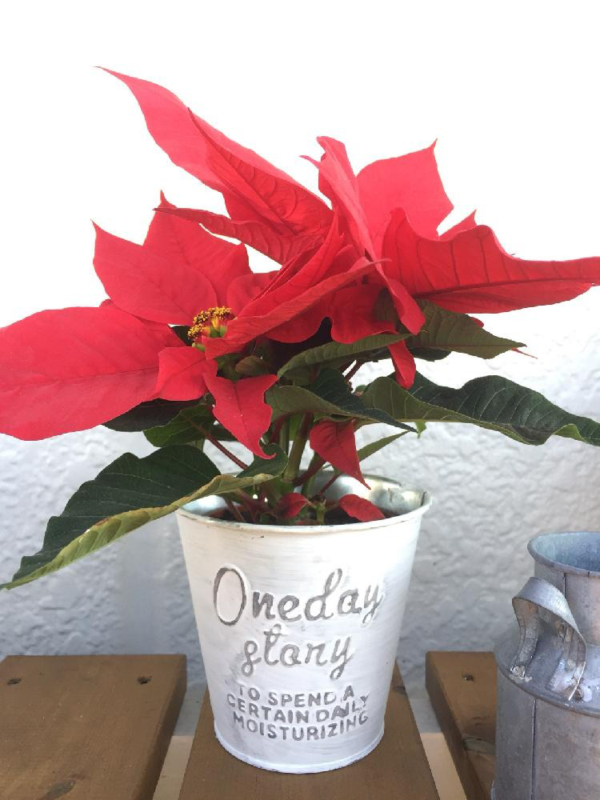